## LEARNING MULTI-SCALE LOCAL CONDITIONAL PROBABILITY MODELS OF IMAGES

Ce travail cherche a présenter et reproduire les résultats obtenus dans une publication de Zahra Kadkhodaie, Florentin Guth, Stéphane Mallat et Eero P. Simoncelli.

Travail réalisé par Constantin DEUMIER et Roman Beauvallet

## Problématique
Les réseaux de neurones capturent des structures complexes sans souffrir de la *curse of dimensionality*, mais les mécanismes restent mal compris.

## Approche
- **Décomposition multi-échelle** : Réduction de dimensionnalité via la transformée en ondelettes
- **Modèle Markov local** : Hypothèse de stationnarité et dépendances locales
- **CNN à champs réceptifs** (RF) :
  - Locaux pour les détails
  - Globaux pour la bande passe-bas


Pour réaliser ce travail. Nous nous somme appuyé sur l'implémentation apporté par les auteurs de cet article, notament pour les poids des CNNs :  https://github.com/LabForComputationalVision/local-probability-models-of-images




In [4]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Computer Modern par défaut
    "font.serif": ["Computer Modern"],  # Facultatif, plus explicite
    "axes.labelsize": 14,
    "font.size": 14,
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# Add researcher's code path
sys.path.insert(0, 'code') 
from wavelet_func import multi_scale_decompose, multi_scale_denoising
from plotting_func import plot_all_coeffs
from model_loader_func import load_multi_scale_denoisers_RF, load_BF_CNN_RF
from quality_metrics_func import batch_ave_psnr_torch
from algorithm_inv_prob import multi_scale_synthesis


Running on device: cpu


In [2]:
def load_and_prep_image(image_path, size=(160, 160)):
    """Loads an image, converts to grayscale, resizes, and turns into a Tensor."""
    # Open image and convert to Grayscale ('L') as per the paper's experiments
    img = Image.open(image_path).convert('L') 
    
    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor() # Converts [0, 255] to [0.0, 1.0]
    ])
    
    return transform(img).unsqueeze(0).to(device)

image_path = "face.jpeg" 

if os.path.exists(image_path):
    test_im = load_and_prep_image(image_path)
    print(f"Image loaded with shape: {test_im.shape}")
else:
    print("Please provide a valid image path to proceed.")
    test_im = torch.rand(1, 1, 160, 160).to(device)

Image loaded with shape: torch.Size([1, 1, 160, 160])


## Transformée en ondelettes 

- **Décomposition** : L'image est séparée en :
  - **Détails** (hautes fréquences) à chaque échelle
  - **Basse fréquence** (image floutée) à chaque niveau

- **Notre code** :
  - 3 niveaux de décomposition (`J=3`)
  - 3 images de détails + 1 image finale basse fréquence

- **Avantage** : Traite les composantes fréquentielles séparément (utile pour le débruitage).


Visualizing the Iterative Wavelet Transform:


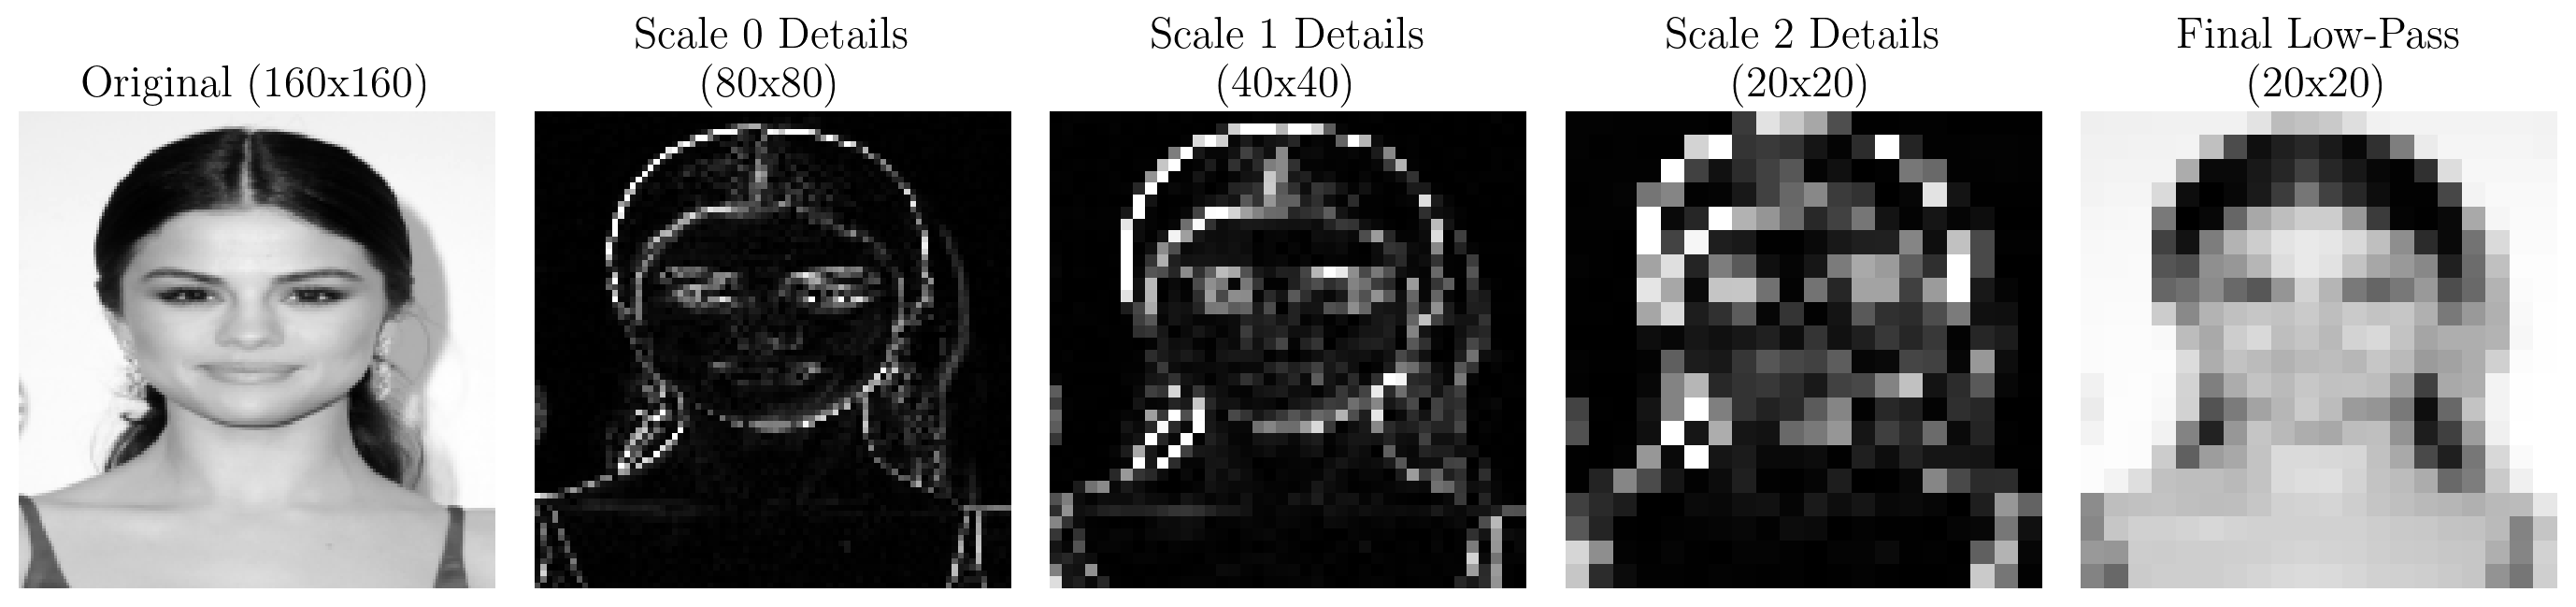

In [6]:
def display_wavelet_hierarchy(image_tensor, J=2):
    """
    Custom plotter to show the iterative decomposition process.
    Shows: Input -> [Scale 0 Details] -> LowPass 0 -> [Scale 1 Details] -> LowPass 1
    """
    coeffs = multi_scale_decompose(image_tensor, J, device=device)
    fig = plt.figure(figsize=(14, 6))
    
    ax = fig.add_subplot(1, J+2, 1)
    ax.imshow(image_tensor.squeeze().cpu(), cmap='gray')
    ax.set_title("Original (160x160)")
    ax.axis('off')
    
    current_res = 160
    
    for j in range(J):
        # The decomposition at scale j gives us High Freqs (Details) and a Low Freq (Next Input)
        c = coeffs[j].squeeze().cpu() # [4, H, W]
        low_pass = c[0]
        details = c[1:].mean(dim=0) # Average the 3 detail channels for visualization
        
        current_res //= 2
        
        ax_d = fig.add_subplot(1, J+2, j+2)
        ax_d.imshow(details.abs(), cmap='gray', vmax=details.abs().max()*0.5) # Better contrast
        ax_d.set_title(f"Scale {j} Details\n({current_res}x{current_res})")
        ax_d.axis('off')
        
    # This is the last Low Pass image that the network actually sees globally
    final_low = coeffs[-1][0, 0].cpu()
    ax_final = fig.add_subplot(1, J+2, J+2)
    ax_final.imshow(final_low, cmap='gray')
    ax_final.set_title(f"Final Low-Pass\n({current_res}x{current_res})")
    ax_final.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Visualizing the Iterative Wavelet Transform:")
display_wavelet_hierarchy(test_im, J=3)

## Expérience 1 : Comparaison des modèles de débruitage
### Objectif
Évaluer l'efficacité du débruitage dans l'espace des pixels *v.s.* l'espace des ondelettes. 

### Protocole expérimental
1. **Préparation des données** :
   - Image de référence
   - Ajout de bruit gaussien de variance croissante (σ ∈ [3.2, 631])

2. **Modèles comparés** :
   - **Modèle Pixel** :
     - Architecture : CNN standard 
     - Entrée : Image bruitée en espace pixel
     - Sortie : Image débruitée

   - **Modèle Ondelettes** :
     - Architecture : CNN multi-échelle
     - Entrée : Coefficients d'ondelettes (décomposition pyramidale présentée dans l'étude)
     - Sortie : Coefficients débruités
     - Reconstruction finale par transformée en ondelettes inverse

3. **Métriques d'évaluation** :
   - PSNR pour évaluer la qualité de reconstruction
   - Temps de calcul pour évaluer l'efficacité
   - Robustesse au bruit 

4. **Analyse attendue** :
   - Comparaison des performances en fonction du niveau de bruit
   - Étude des artefacts de reconstruction
   - Analyse des composantes fréquentielles préservées


Loading models...
Running Denoising Experiment (RF=13x13)...
Sigma: 3.2 | Flat PSNR: 38.96 | Wavelet PSNR: 41.89


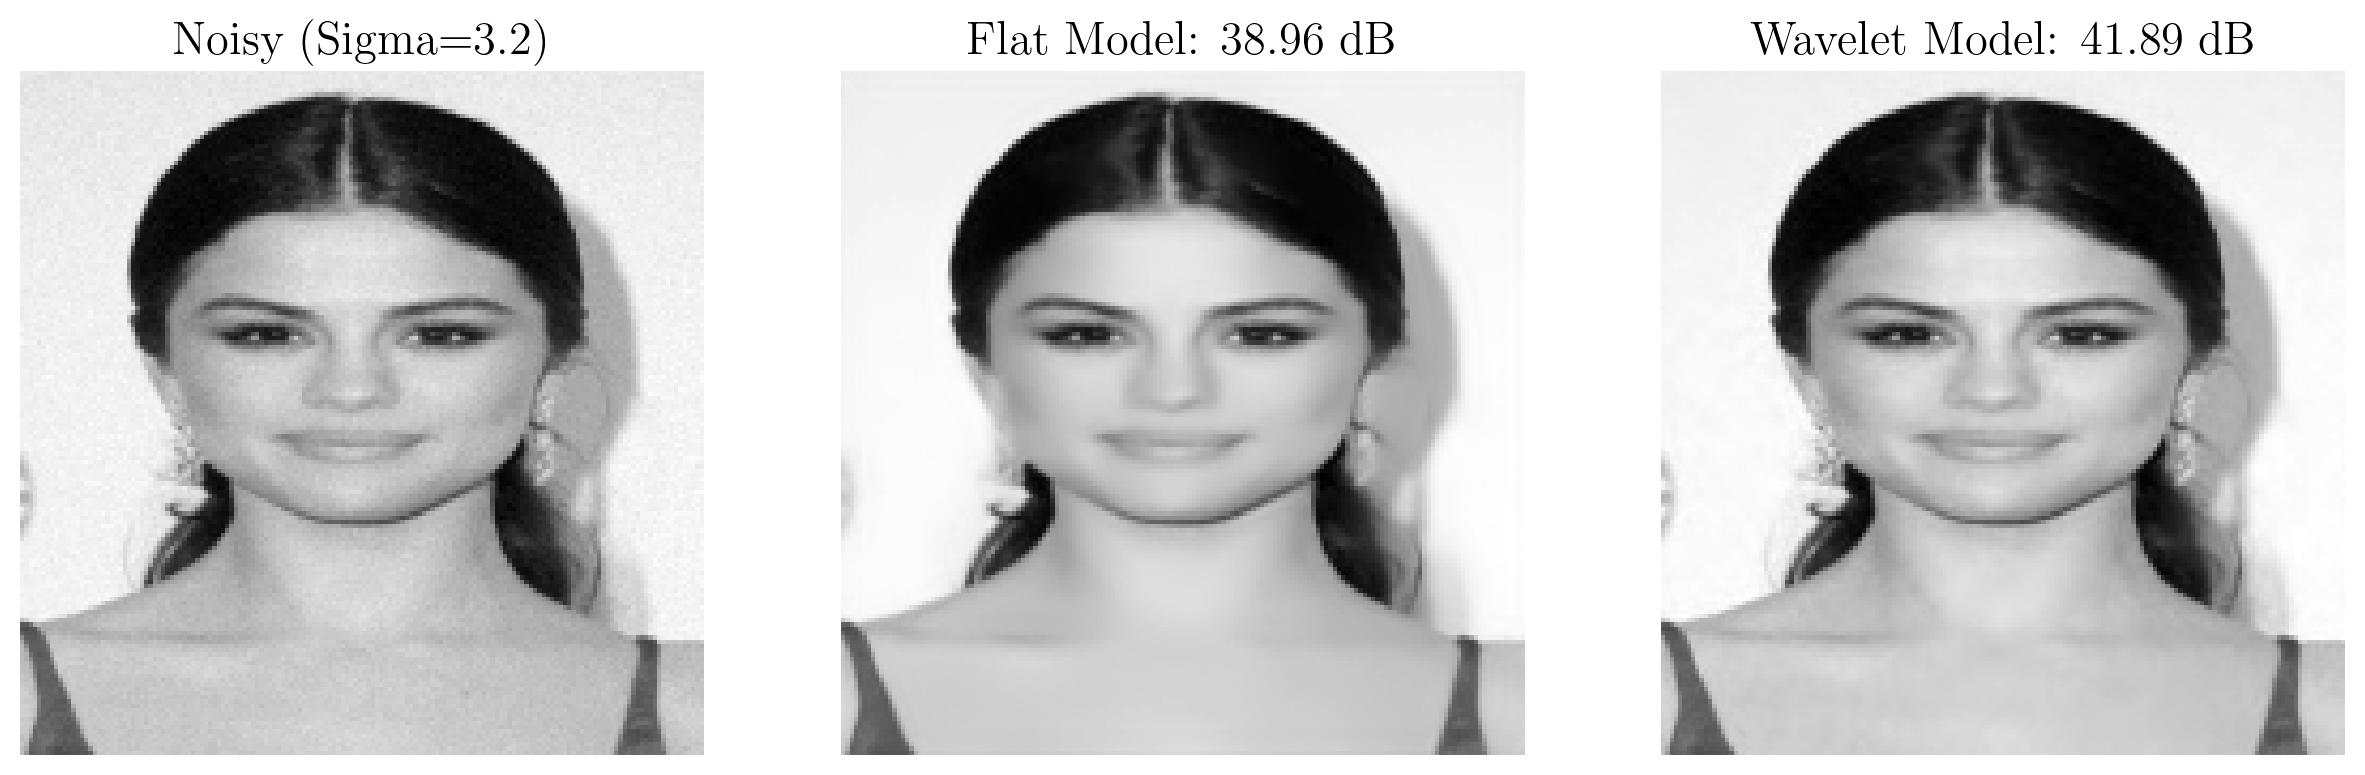

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.02, Max=1.00
Wavelet Output:          Min=0.02,   Max=1.00
Sigma: 5.7 | Flat PSNR: 37.15 | Wavelet PSNR: 38.68


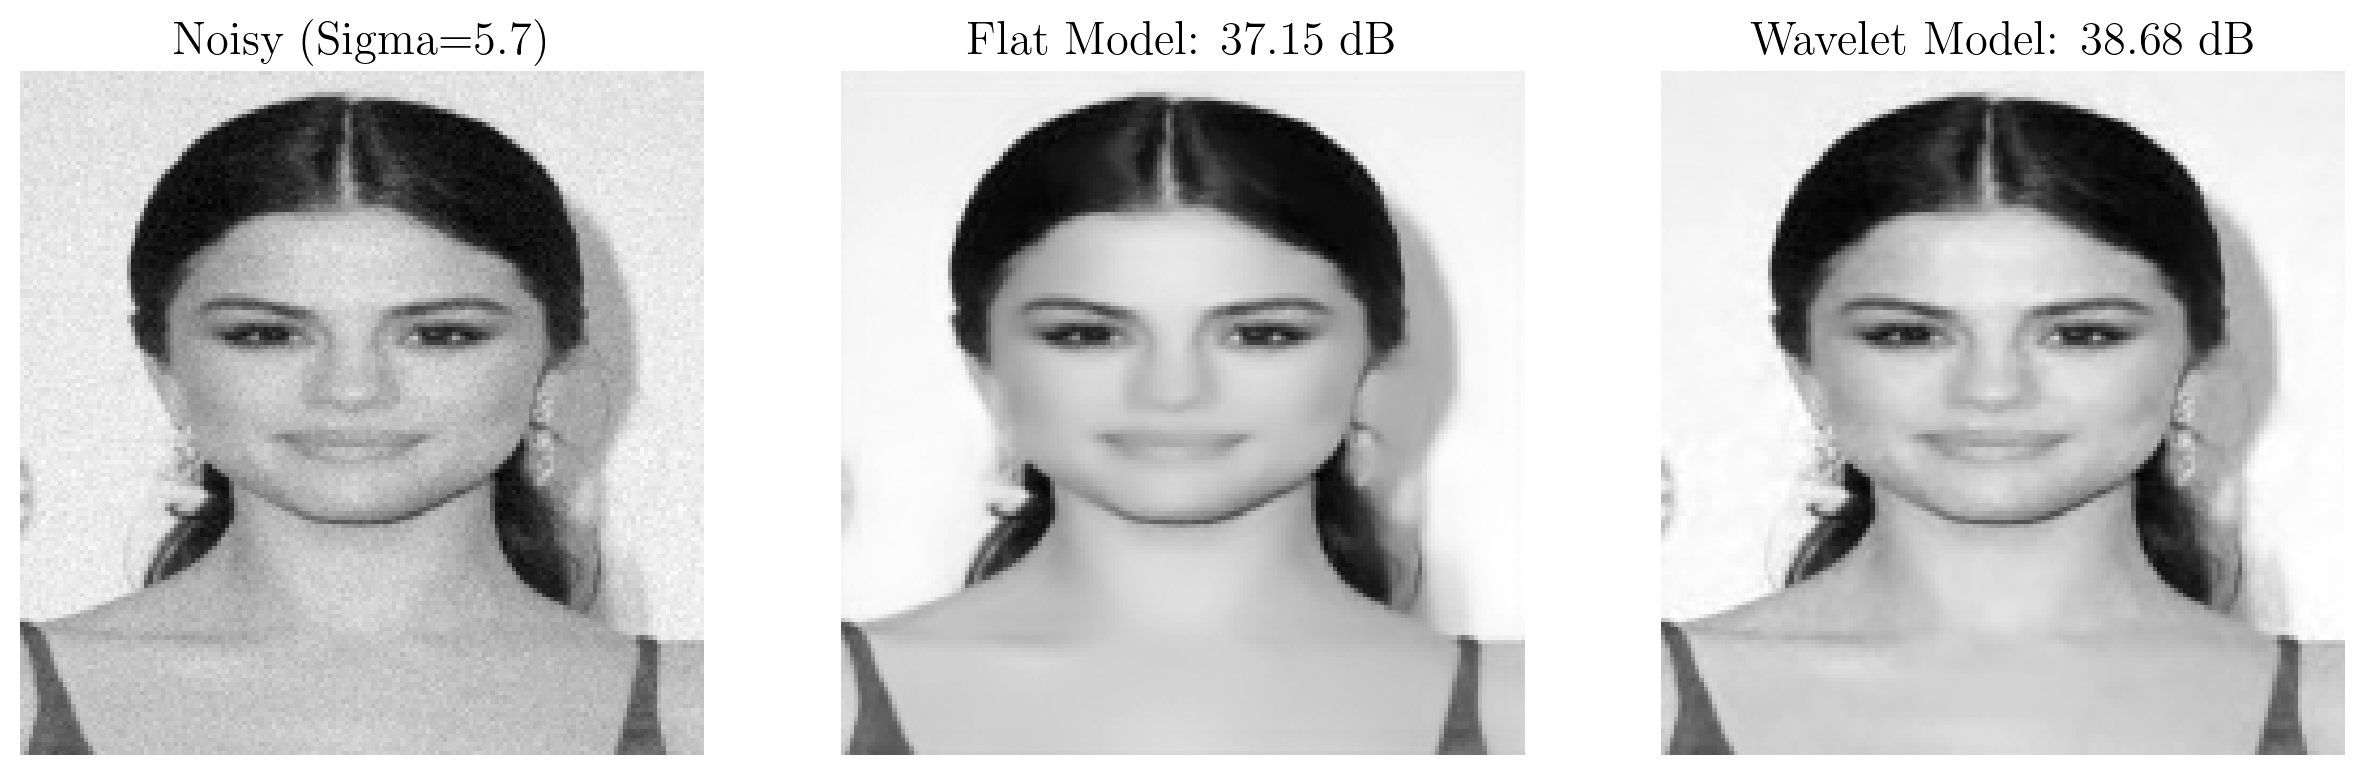

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.00,   Max=1.00
Sigma: 10.3 | Flat PSNR: 34.94 | Wavelet PSNR: 35.64


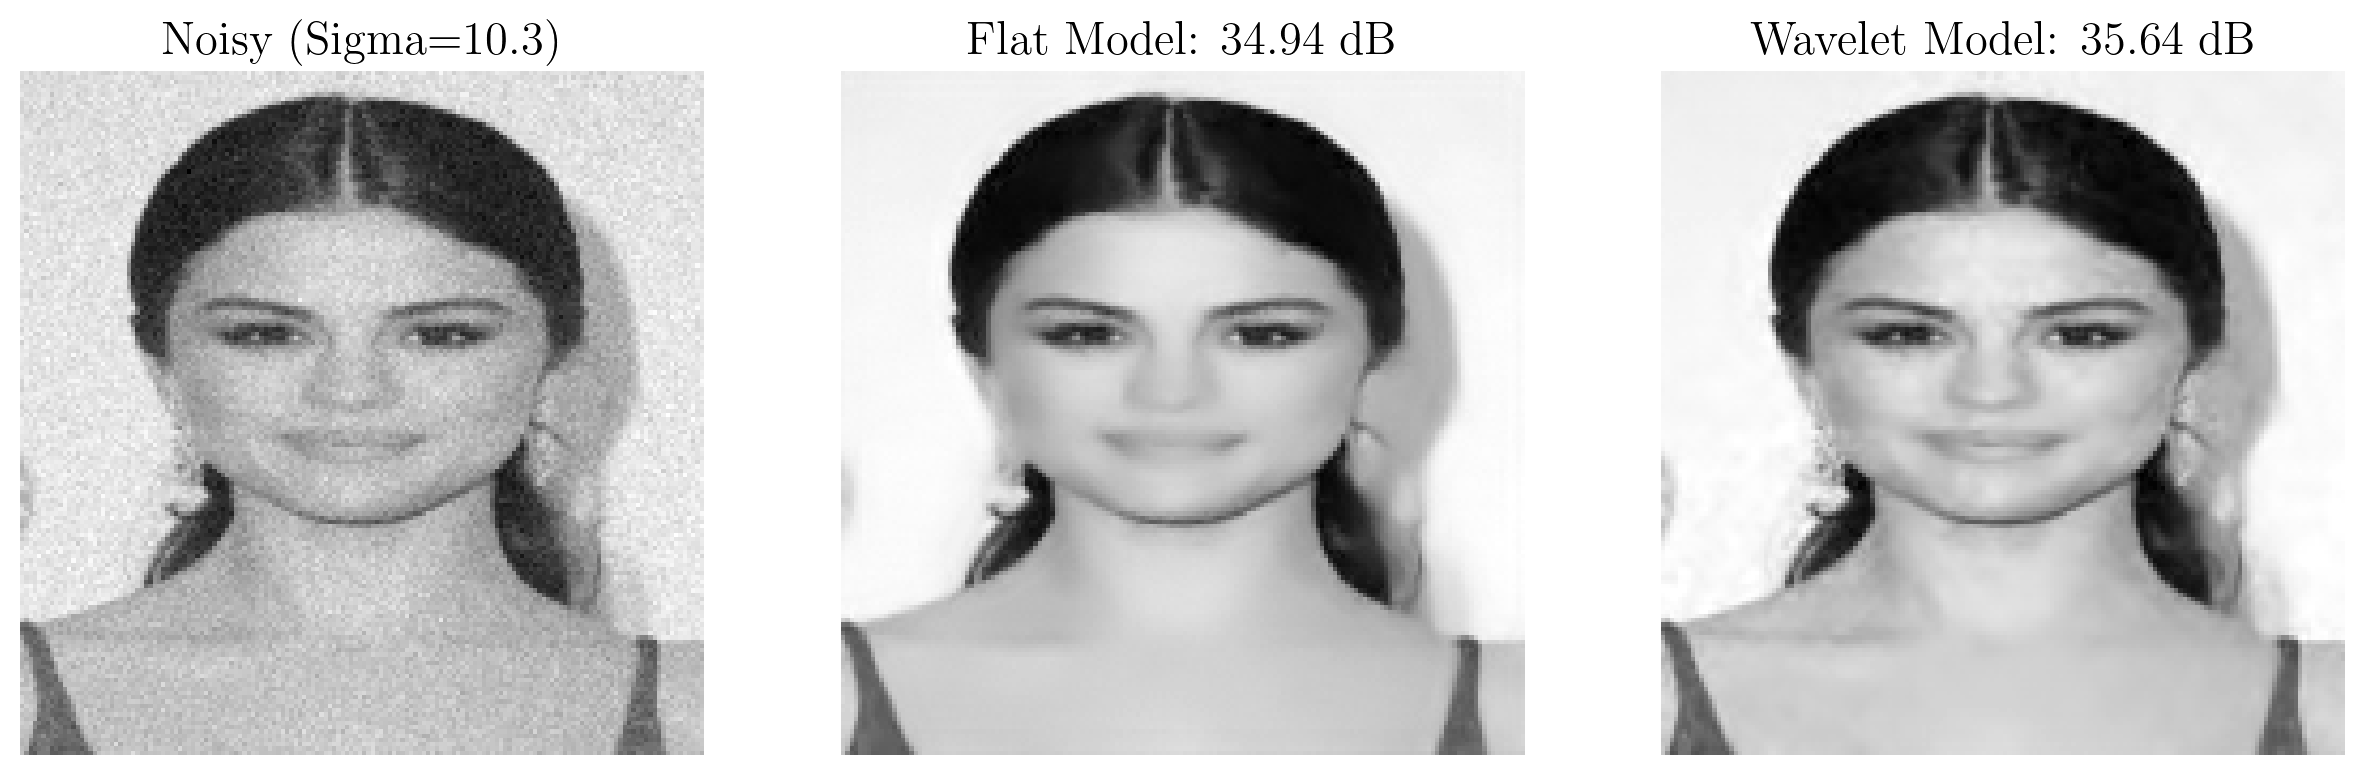

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.00,   Max=1.00
Sigma: 18.5 | Flat PSNR: 32.63 | Wavelet PSNR: 33.02


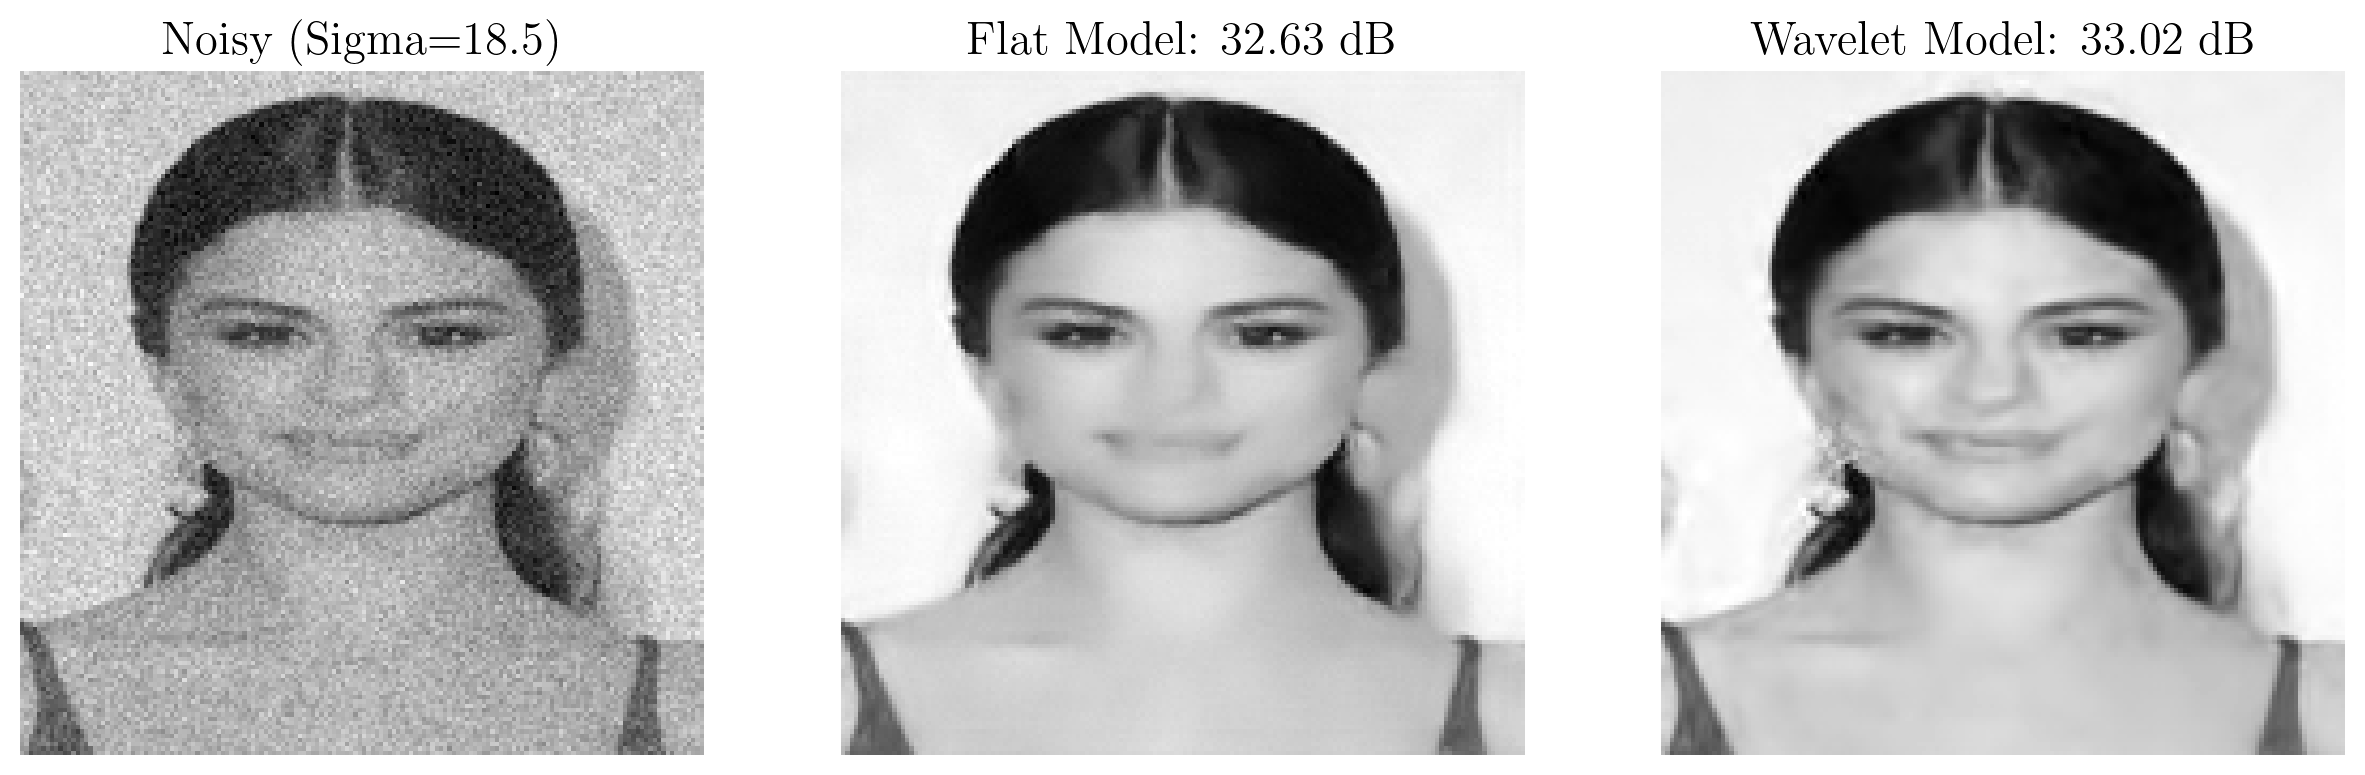

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.00,   Max=1.00
Sigma: 33.3 | Flat PSNR: 29.75 | Wavelet PSNR: 30.21


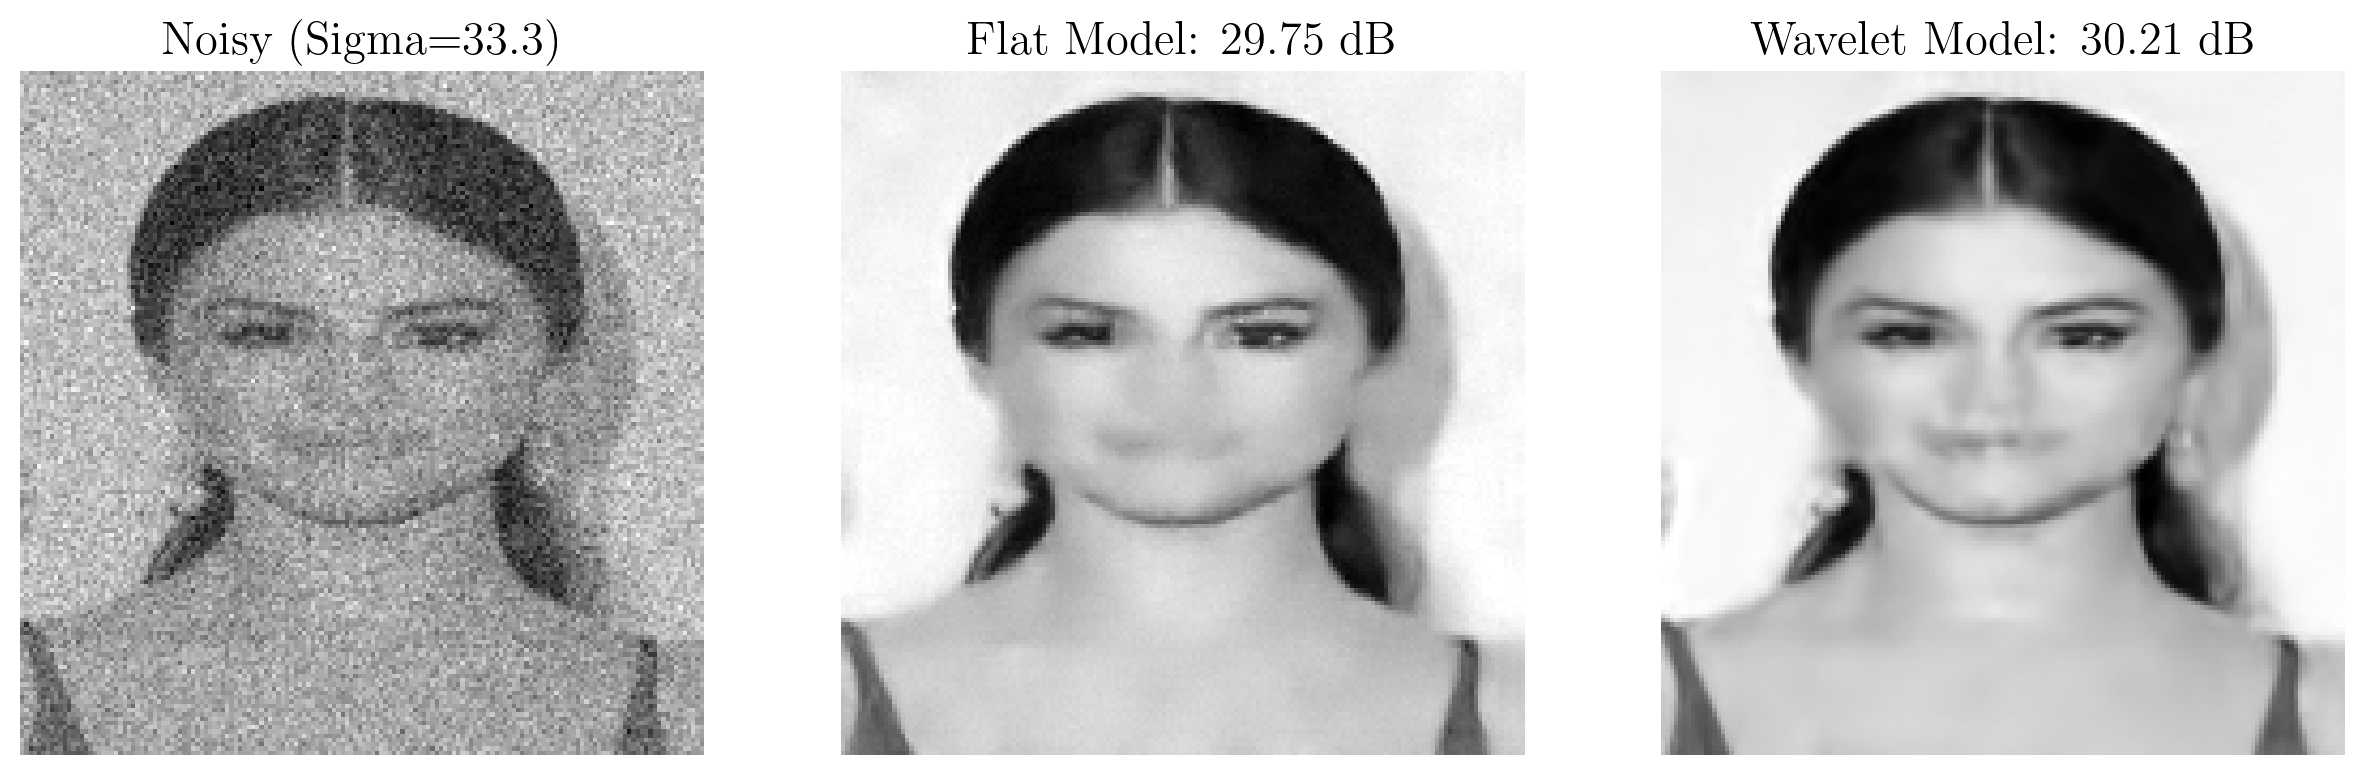

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.01, Max=1.00
Wavelet Output:          Min=0.02,   Max=1.00
Sigma: 59.9 | Flat PSNR: 26.95 | Wavelet PSNR: 27.73


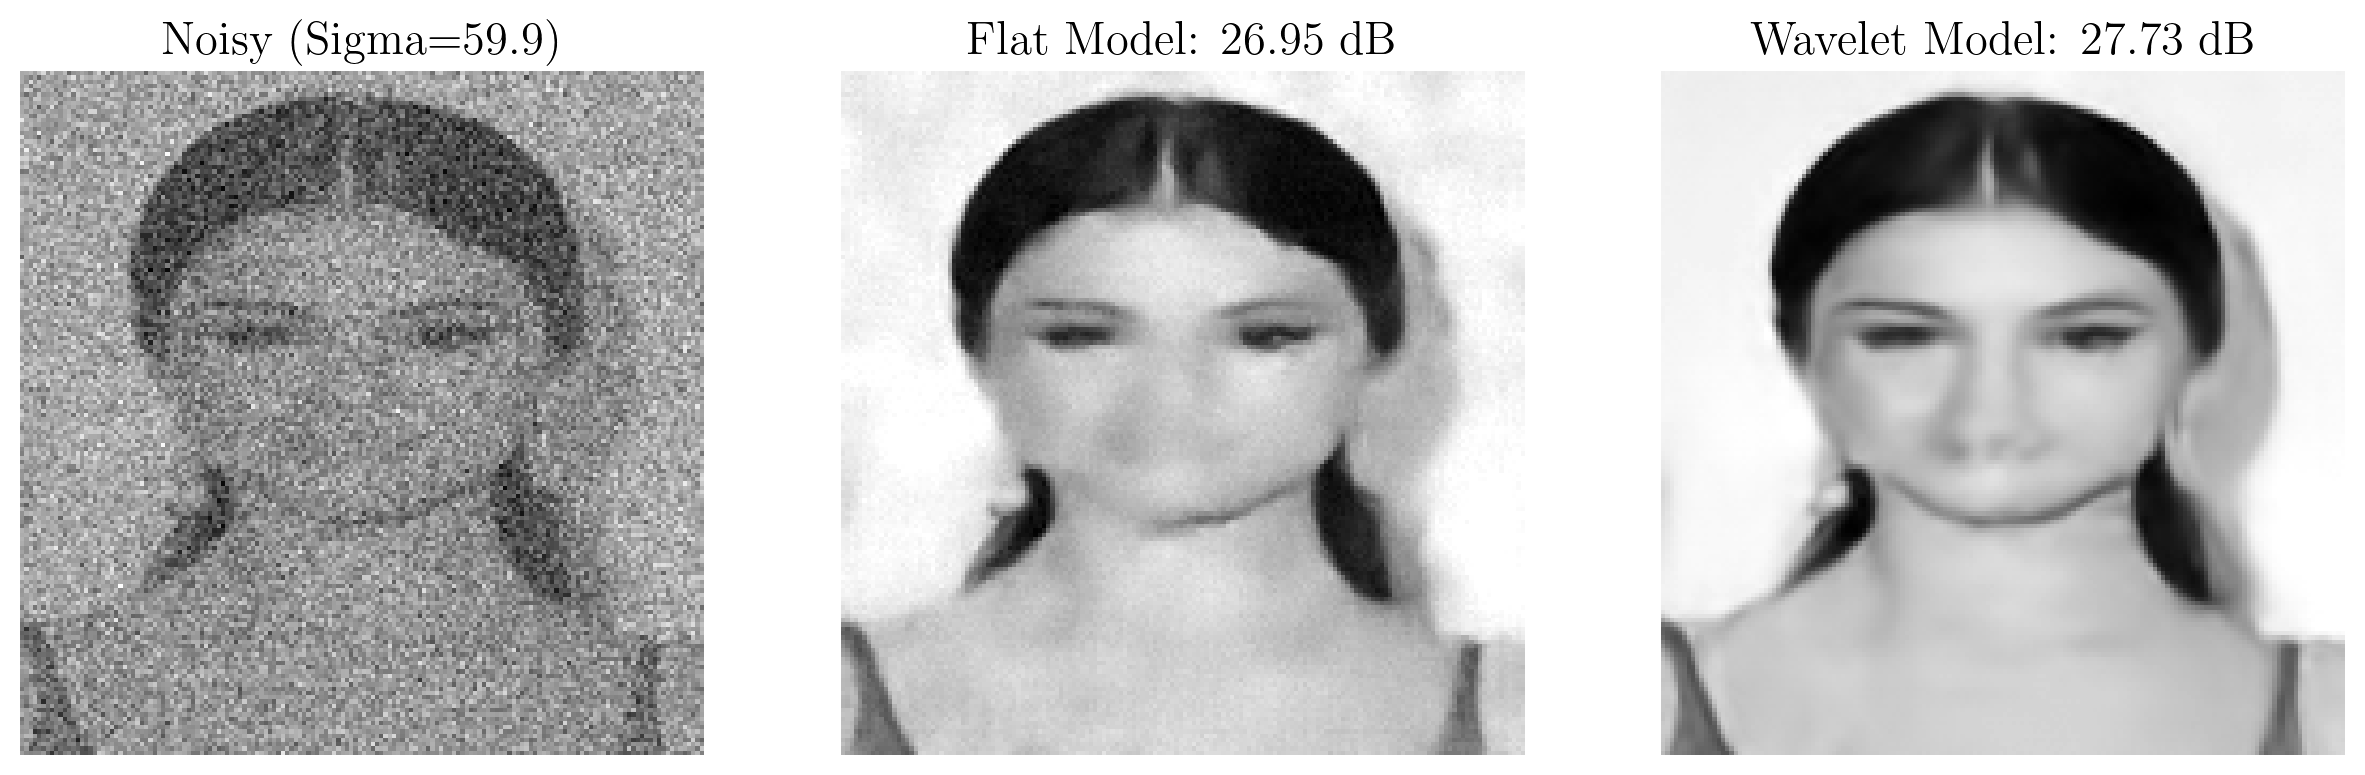

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.02,   Max=1.00
Sigma: 108.0 | Flat PSNR: 23.44 | Wavelet PSNR: 24.69


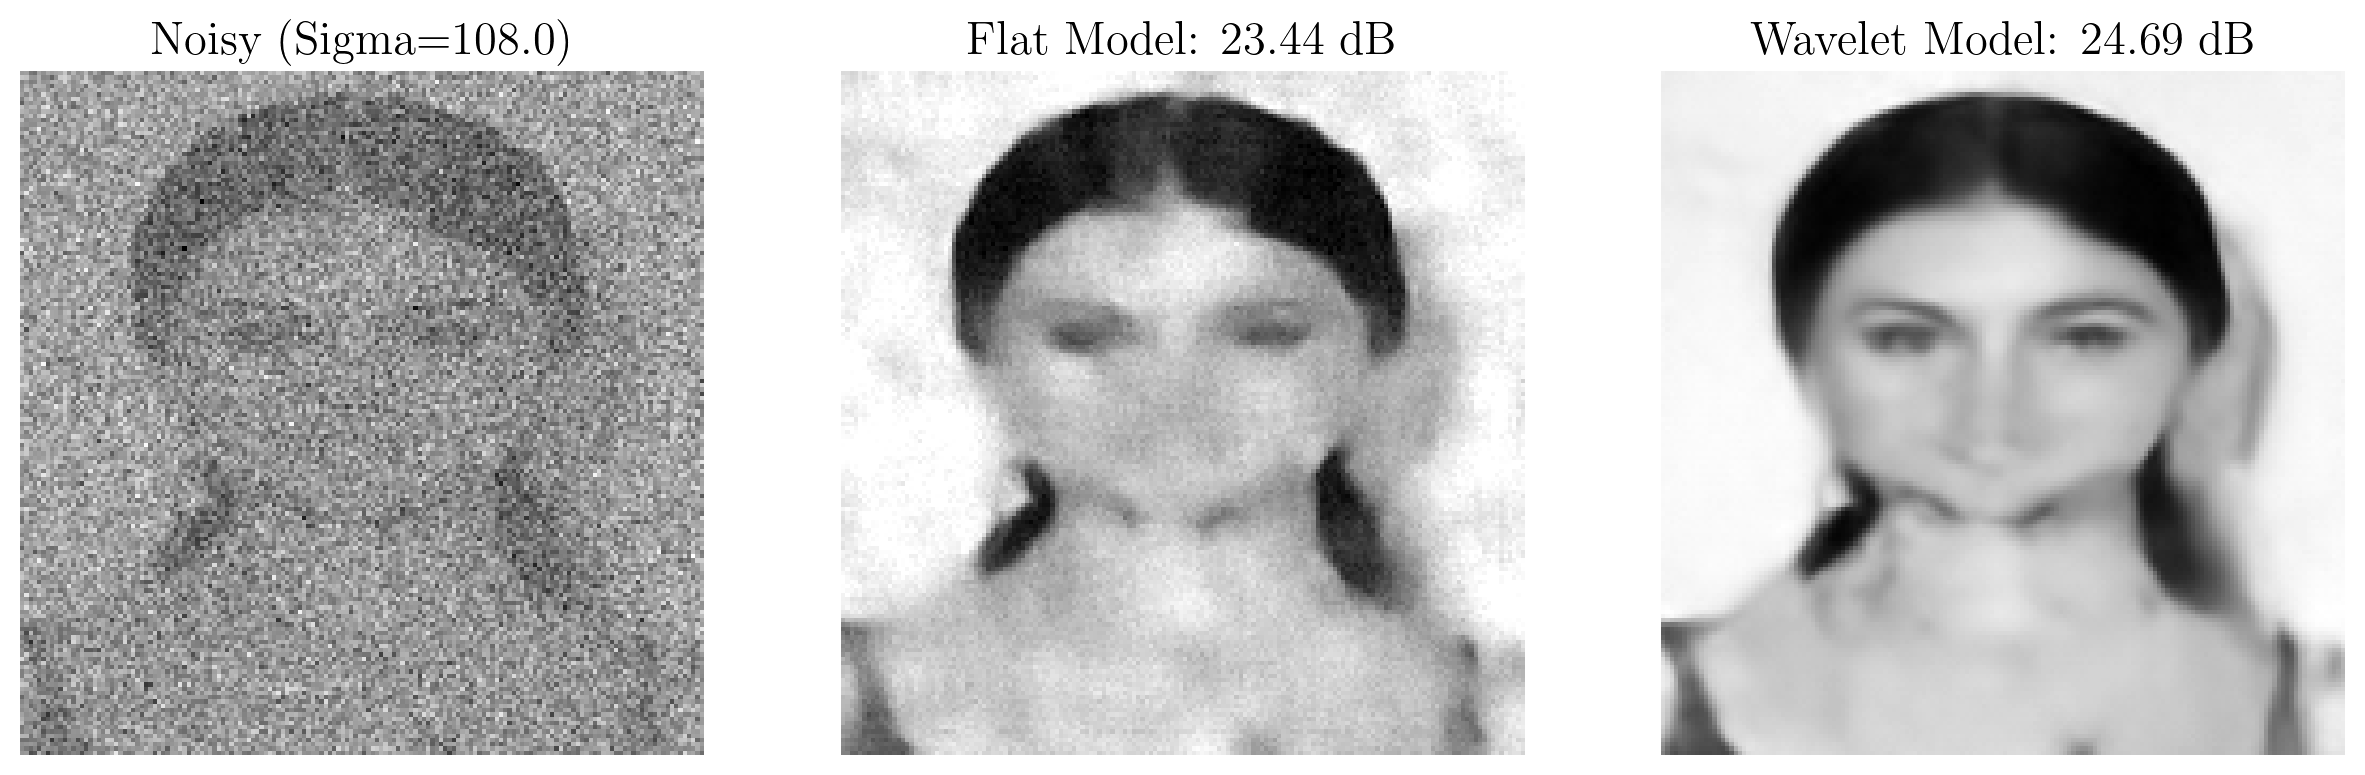

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.03,   Max=1.00
Sigma: 194.5 | Flat PSNR: 19.91 | Wavelet PSNR: 22.05


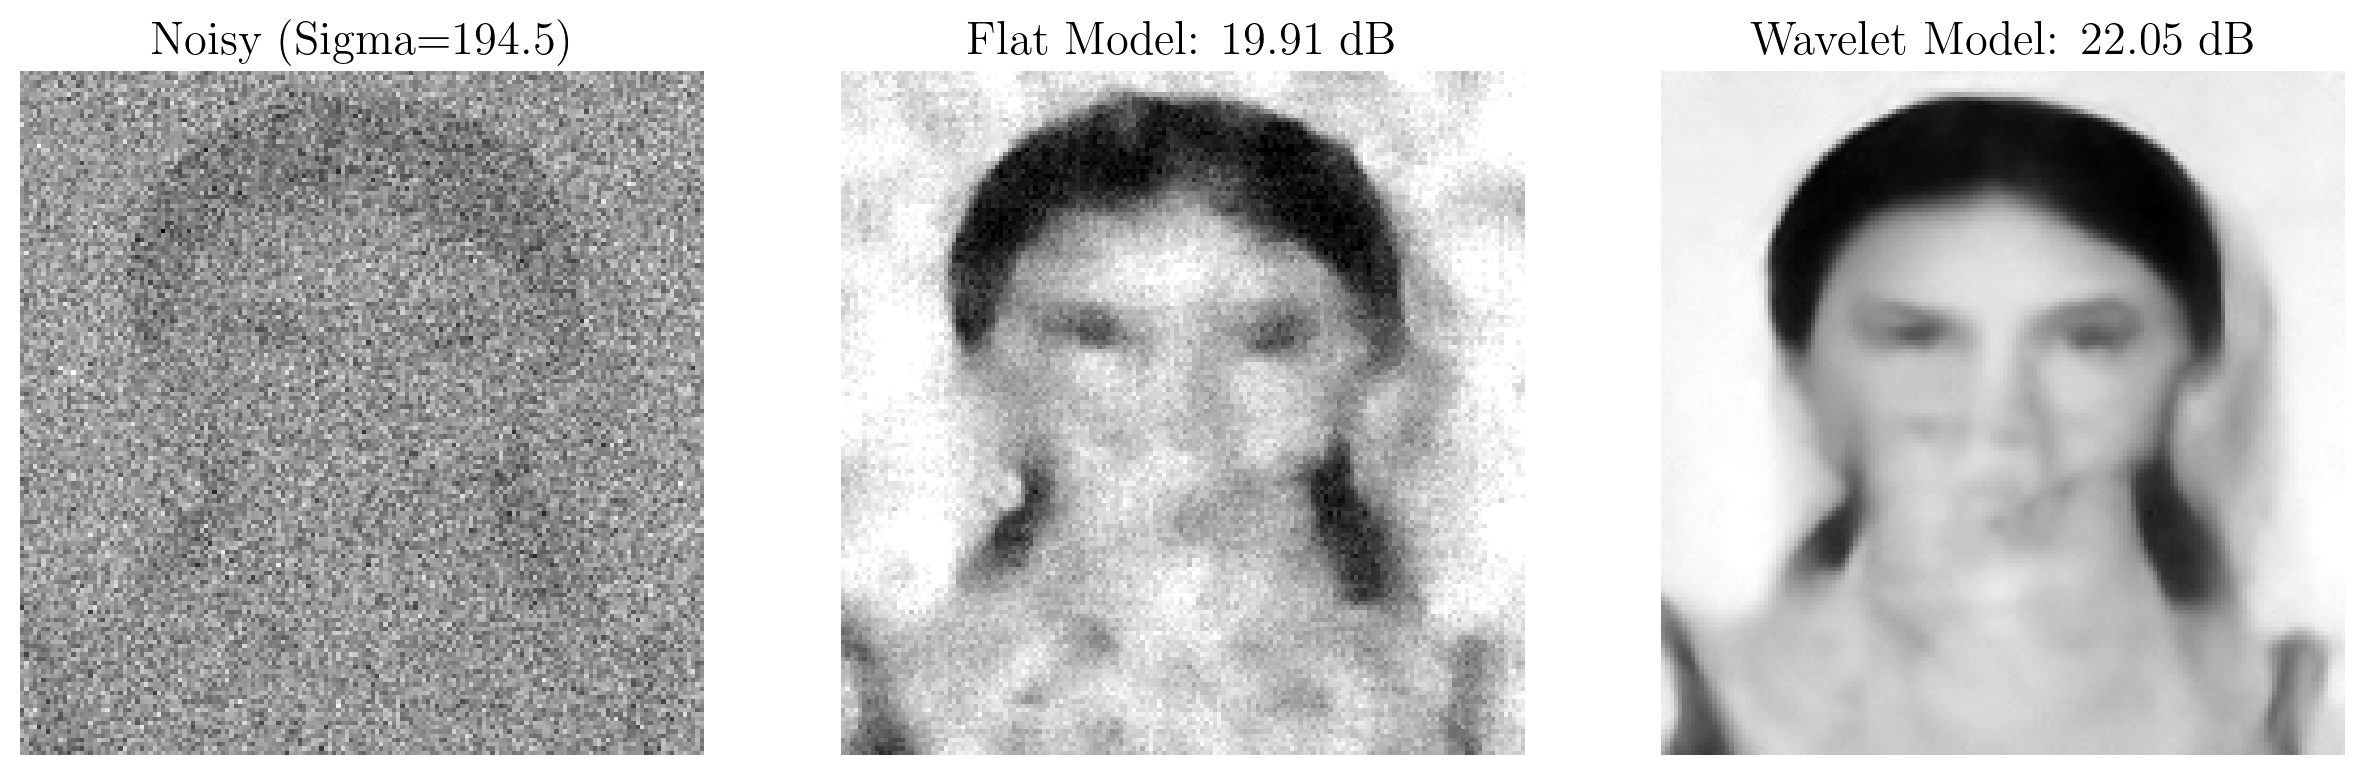

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.04,   Max=1.00
Sigma: 350.3 | Flat PSNR: 16.35 | Wavelet PSNR: 19.37


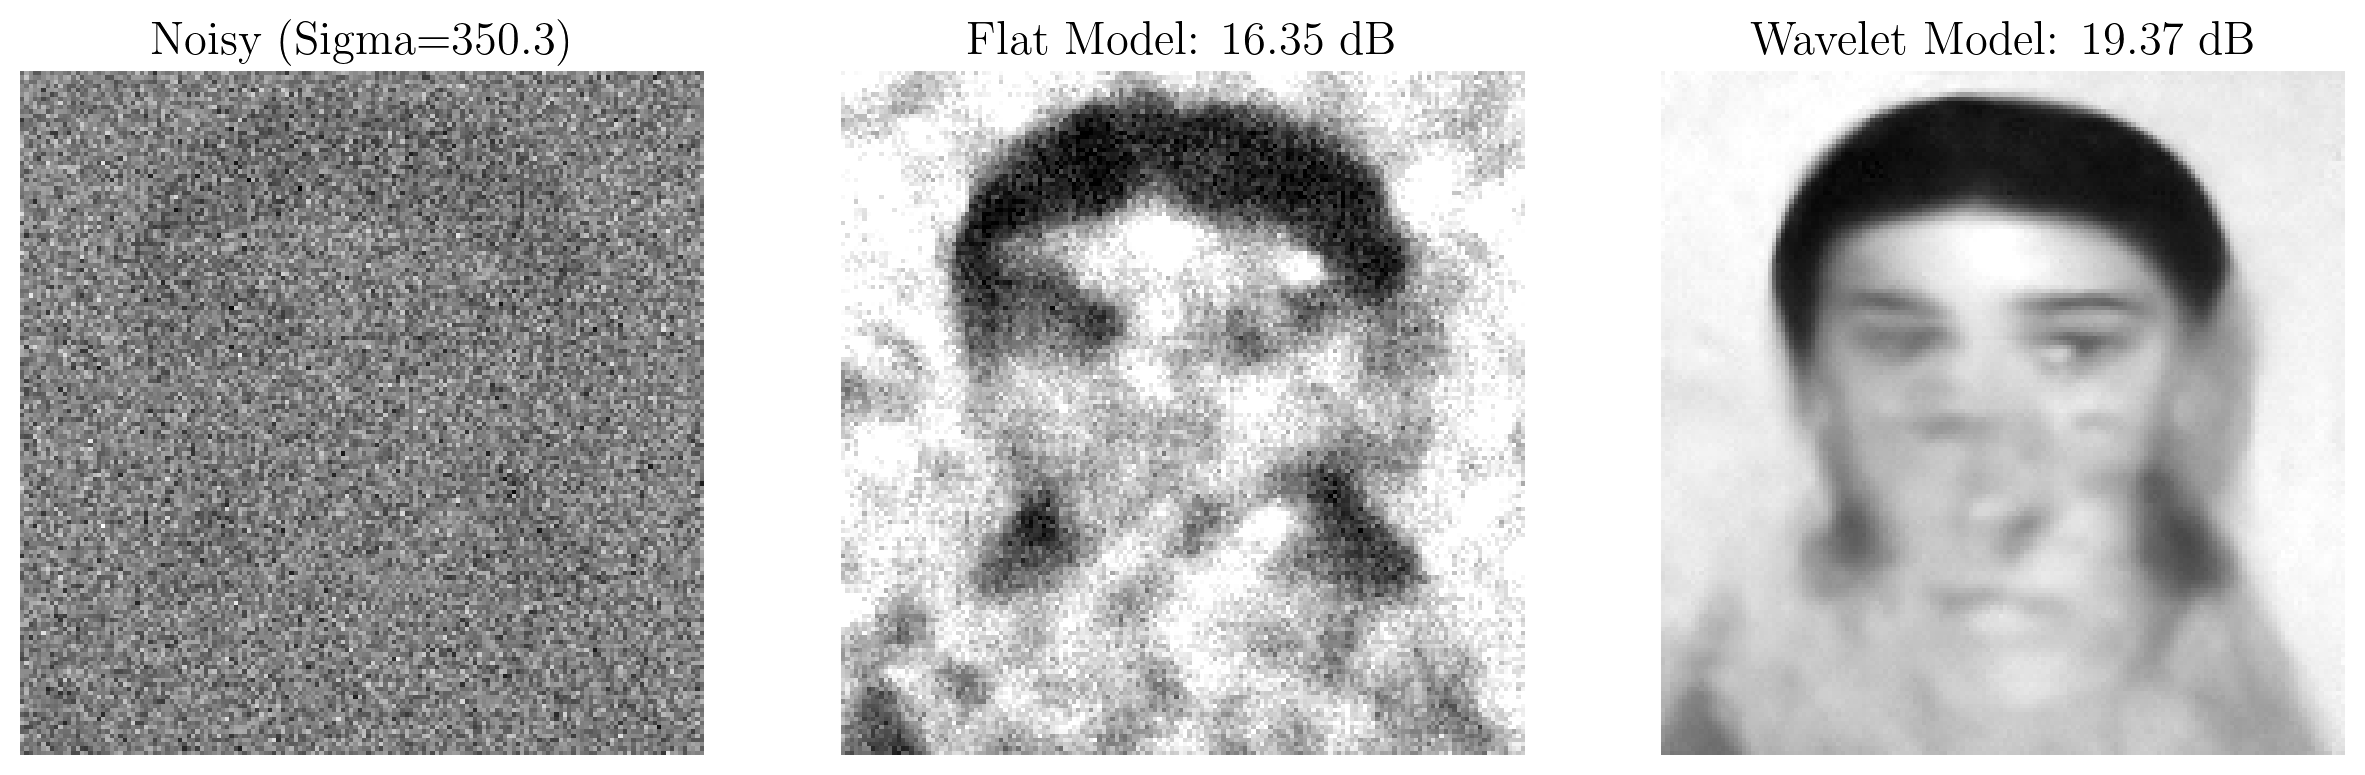

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.02,   Max=1.00
Sigma: 631.0 | Flat PSNR: 12.43 | Wavelet PSNR: 17.18


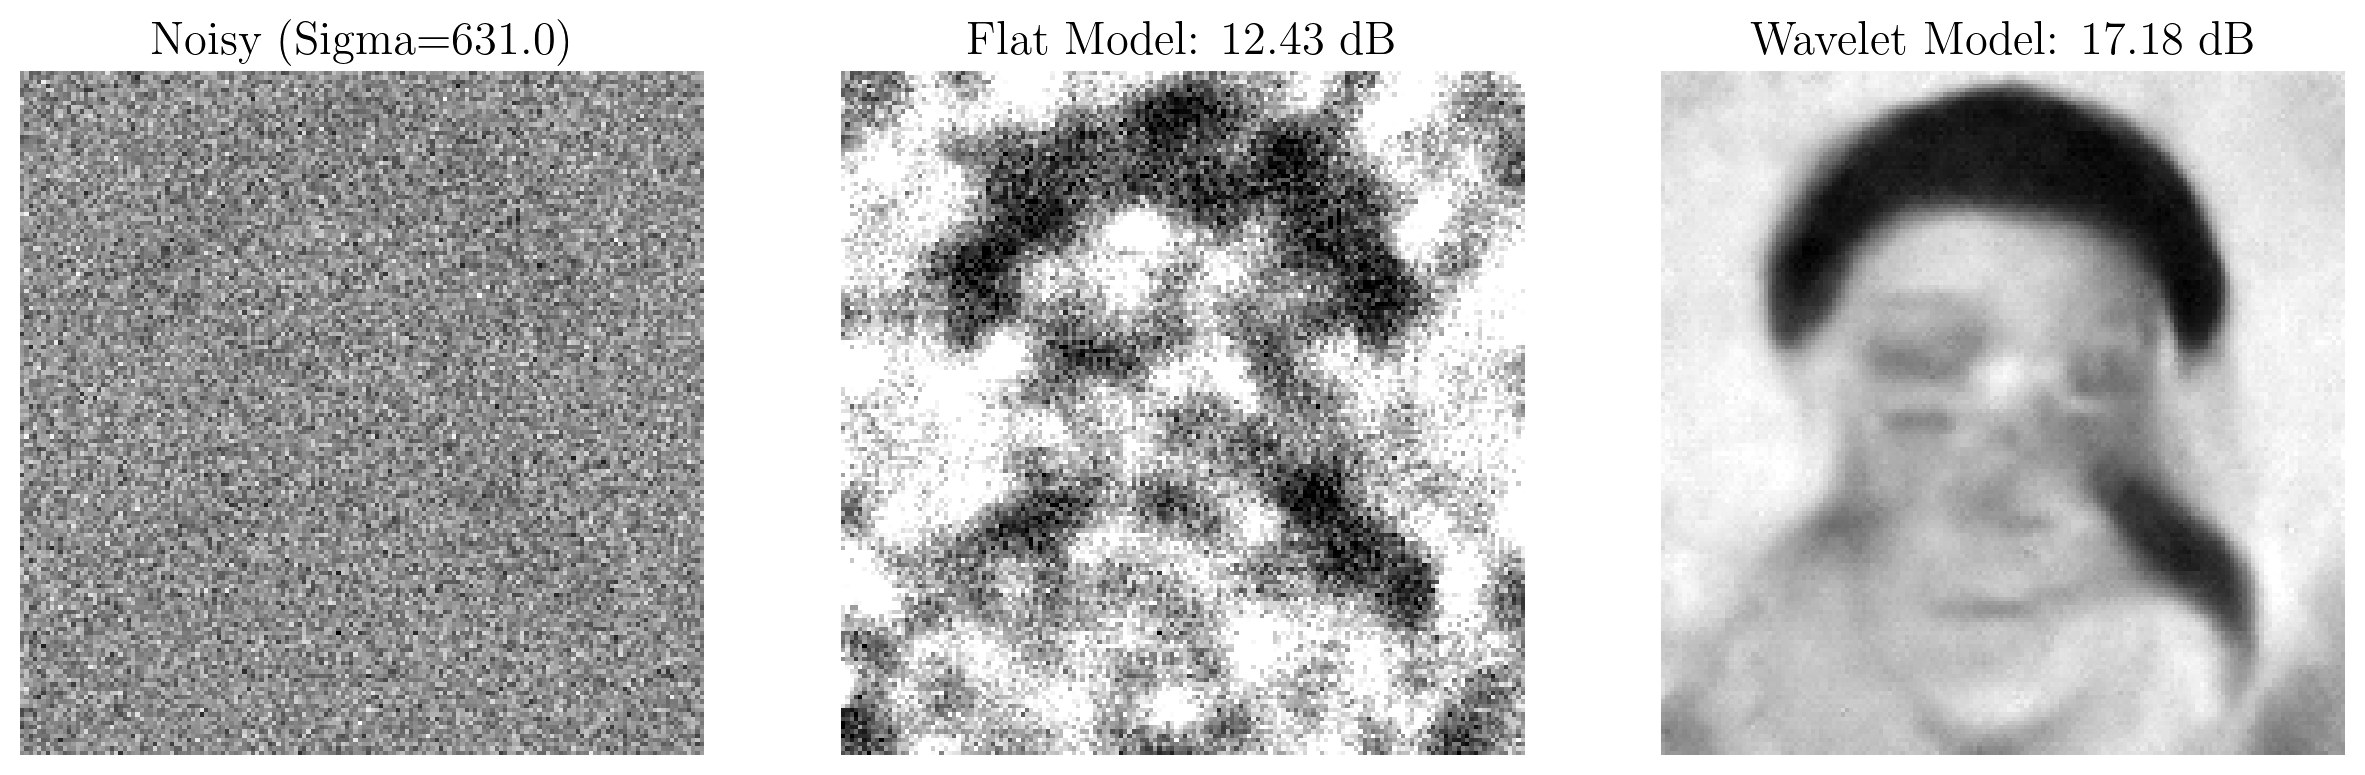

--- Debugging Data Ranges ---
Clean Image (test_im):   Min=0.03, Max=1.00
Flat Output:             Min=0.00, Max=1.00
Wavelet Output:          Min=0.09,   Max=1.00


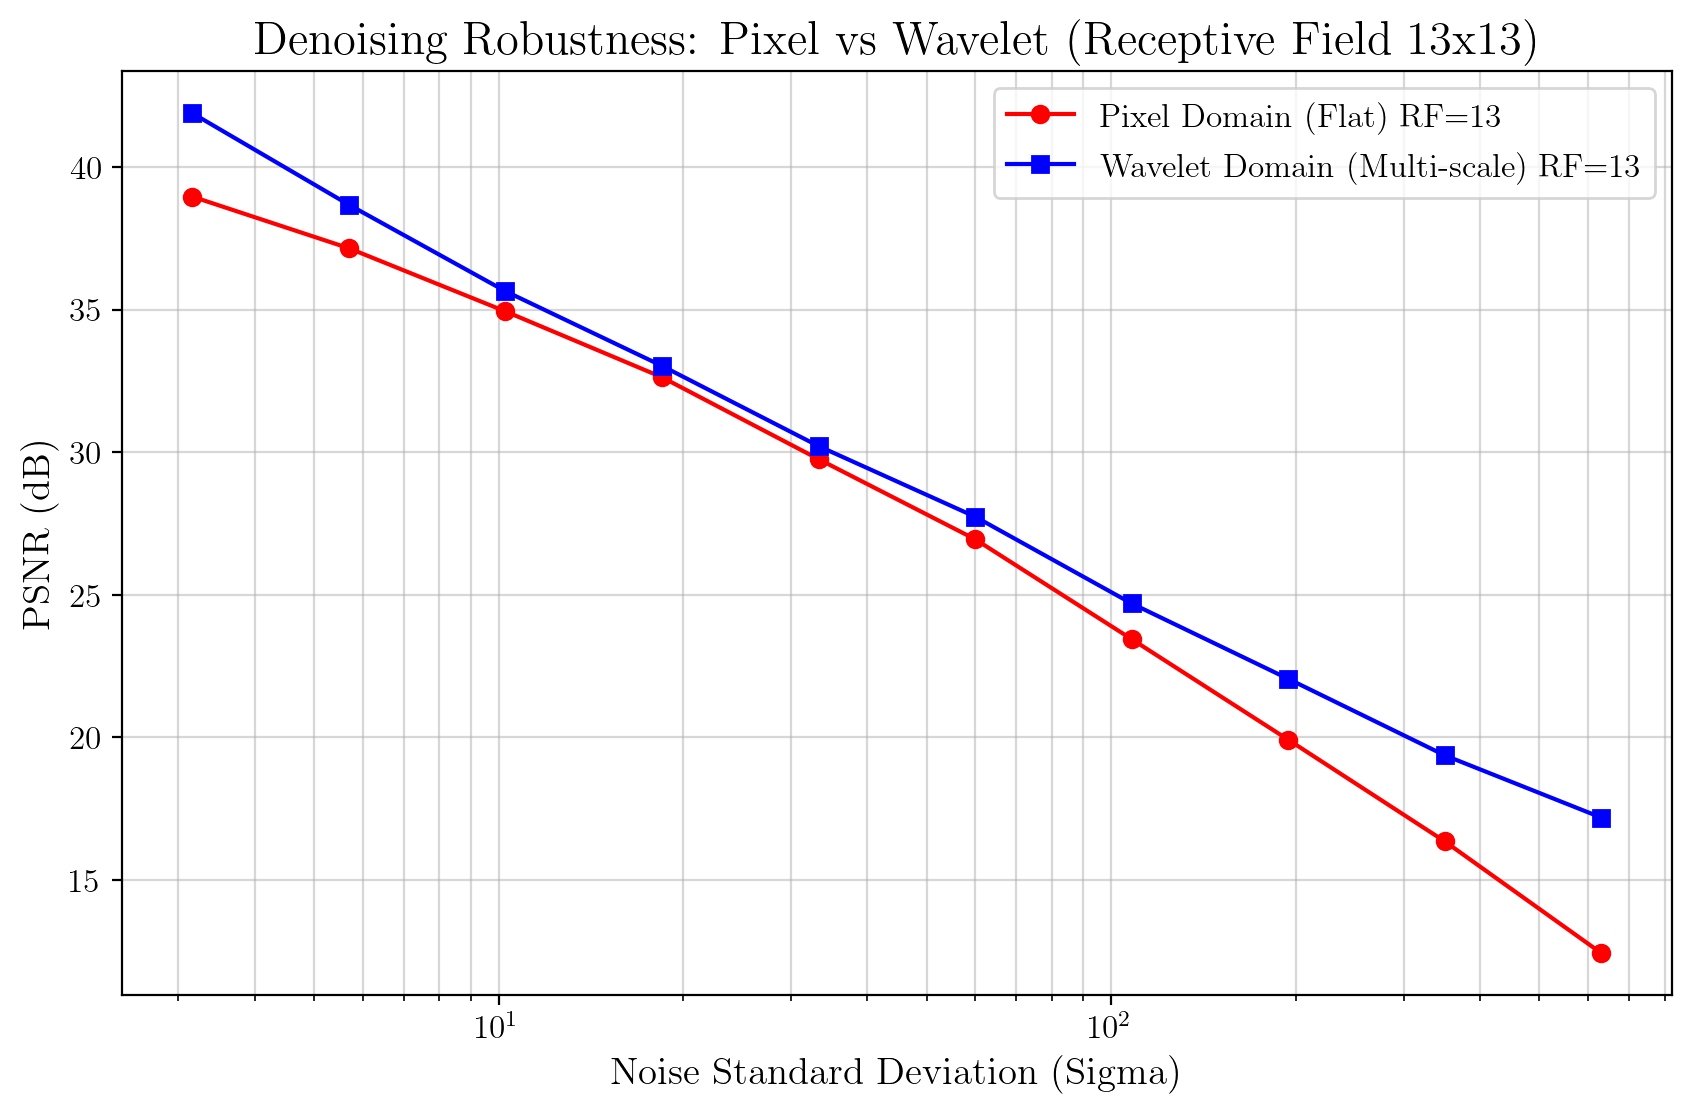

In [7]:
base_path = 'denoisers' 
training_data_name = 'celebA_160x160_gray'
training_noise = 'noise_range_0to255'
RF_SIZE = 13  # We compare Receptive Field of 13x13 as in the paper's demo

# --- 1. Load Models ---
print("Loading models...")

# Load Model A: Flat Pixel-Space Denoiser
flat_denoiser = load_BF_CNN_RF(base_path, training_data_name, training_noise, RF=RF_SIZE)
flat_denoiser.eval()

# Load Model B: Multi-Scale Wavelet Denoiser

ms_denoisers = load_multi_scale_denoisers_RF(base_path, training_data_name, training_noise, RF_low=40, RF=RF_SIZE, J=2)
for k in ms_denoisers:
    ms_denoisers[k].eval()
# --- 2. Define Noise Range ---
denoising_range = torch.logspace(0.5, 2.8, 10).to(device)

# --- 3. Evaluation Loop ---
flat_psnrs = []
ms_psnrs = []

print(f"Running Denoising Experiment (RF={RF_SIZE}x{RF_SIZE})...")

for sigma in denoising_range:
    clean = test_im
    noise = torch.randn_like(clean, device=device) * sigma / 255
    noisy_im = clean + noise
    
    # --- Model A: Flat Denoising ---
    with torch.no_grad():
        # 1. Mise à l'échelle 0-255 (comme les poids du modèle l'attendent probablement)
        input_scaled = noisy_im * 255.0
        
        # 2. Le modèle prédit le BRUIT (Residual)
        predicted_noise = flat_denoiser(input_scaled)
        
        # 3. On soustrait le bruit : Image = (Input - Bruit)
        denoised_scaled = input_scaled - predicted_noise
        
        # 4. On repasse en 0-1
        denoised_flat = denoised_scaled / 255.0

    
    denoised_flat = torch.clamp(denoised_flat, 0.0, 1.0)

    # Calculate PSNR
    flat_score = batch_ave_psnr_torch(clean.cpu(), denoised_flat.cpu(), 1.0)
    flat_psnrs.append(flat_score)
    
    denoised_ms_list = multi_scale_denoising(noisy_im, ms_denoisers, device=device, orth_forward=True)
    
    # Reverse to get the finest resolution (scale 0) first, consistent with demo.ipynb
    denoised_ms_list.reverse() 
    denoised_ms = denoised_ms_list[0]
    denoised_ms = torch.clamp(denoised_ms, 0.0, 1.0)
    
    # Calculate PSNR
    ms_score = batch_ave_psnr_torch(clean.cpu(), denoised_ms.cpu(), 1.0)
    ms_psnrs.append(ms_score)
    
    print(f"Sigma: {sigma.item():.1f} | Flat PSNR: {flat_score:.2f} | Wavelet PSNR: {ms_score:.2f}")
    # --- Visualization for this noise level ---
    plt.figure(figsize=(15, 5))

    # Noisy Input
    plt.subplot(1, 3, 1)
    plt.imshow(noisy_im.squeeze().cpu(), cmap='gray')
    plt.title(f"Noisy (Sigma={sigma.item():.1f})")
    plt.axis('off')

    # Flat (Pixel) Output
    plt.subplot(1, 3, 2)
    plt.imshow(denoised_flat.squeeze().cpu(), cmap='gray')
    plt.title(f"Flat Model: {flat_score:.2f} dB")
    plt.axis('off')

    # Wavelet (Multi-scale) Output
    plt.subplot(1, 3, 3)
    plt.imshow(denoised_ms.squeeze().cpu(), cmap='gray')
    plt.title(f"Wavelet Model: {ms_score:.2f} dB")
    plt.axis('off')

    plt.show()
    print("--- Debugging Data Ranges ---")
    print(f"Clean Image (test_im):   Min={test_im.min():.2f}, Max={test_im.max():.2f}")
    print(f"Flat Output:             Min={denoised_flat.min():.2f}, Max={denoised_flat.max():.2f}")
    print(f"Wavelet Output:          Min={denoised_ms.min():.2f},   Max={denoised_ms.max():.2f}")

plt.figure(figsize=(10, 6))
plt.plot(denoising_range.cpu().numpy(), flat_psnrs, 'o-', label=f'Pixel Domain (Flat) RF={RF_SIZE}', color='red')
plt.plot(denoising_range.cpu().numpy(), ms_psnrs, 's-', label=f'Wavelet Domain (Multi-scale) RF={RF_SIZE}', color='blue')

plt.xscale('log')
plt.xlabel('Noise Standard Deviation (Sigma)')
plt.ylabel('PSNR (dB)')
plt.title(f'Denoising Robustness: Pixel vs Wavelet (Receptive Field {RF_SIZE}x{RF_SIZE})')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# Expérience 2 : Champs Réceptif (***Receptive Field***)

Pour recréer un pixel, sur quels autres pixels le réseau se base ? 

Pour répondre à cette question mesurons l'influence de chaque pixel sur un pixel pris au centre en mesurant la jacobienne.

In [8]:
def reconstruct( coeffs,device, wavelet='db1', mode='symmetric', orth_forward=True):
    """ One-level wavelet reconstruction, (*, 4, L/2, L/2) to (*,1, L, L), using numpy (CPU, no autodiff). """
    if device.type == 'cuda':
        coeffs = coeffs.cpu()

    channels = tuple(coeffs[..., c, :, :] for c in range(4))
    images = pywt.idwt2((channels[0], channels[1:]), wavelet=wavelet, mode=mode)  # (*, L, L)
    images =  torch.from_numpy(images).unsqueeze(1).to(device) 
    ## multiply by two to compensate for division by 2 of the coeffs in trainig 
    if orth_forward: 
        images = images * 2 
    return images 

def integrity_check(clean_image, device, wavelet='db1', mode='symmetric', orth_forward=True, J=2):
    '''
    Vérifie que Décomposition + Reconstruction = Identité parfaite.
    '''
    # 1. Décomposition (On découpe l'image)

    all_coeffs = multi_scale_decompose(clean_image, J, device=device, wavelet=wavelet, mode=mode, orth_forward=orth_forward)
    
    # On commence par le fond de la pyramide (l'image la plus petite)
    # On la prend telle quelle, SANS passer par le réseau de neurones
    current_image = all_coeffs[-1][:, 0:1] 
    
    # 2. Reconstruction (On remonte la pyramide)
    for j in range(J-1, -1, -1):
        # On récupère les vrais détails (sans passer par le réseau de neurones)
        real_details = all_coeffs[j][:, 1::] 
        
        # On recolle : (Image Basse Def) + (Vrais Détails)
        axis_combined = torch.cat((current_image, real_details), dim=1)
        
        # On applique la transformée inverse
        current_image = reconstruct(axis_combined, device, orth_forward=orth_forward)

    return current_image

In [9]:
class DifferentiableHaar(nn.Module):
    def __init__(self):
        super().__init__()
        # Standard Haar Filters
        self.filters = torch.tensor([[[[0.5, 0.5], [0.5, 0.5]]], [[[0.5, -0.5], [0.5, -0.5]]],
                                     [[[0.5, 0.5], [-0.5, -0.5]]], [[[0.5, -0.5], [-0.5, 0.5]]]])
        self.inv_filters = torch.tensor([[[[0.5, 0.5], [0.5, 0.5]]], [[[0.5, -0.5], [0.5, -0.5]]],
                                         [[[0.5, 0.5], [-0.5, -0.5]]], [[[0.5, -0.5], [-0.5, 0.5]]]])

    def forward_decompose(self, x, orth_forward=True):
        self.filters = self.filters.to(x.device).type(x.dtype)
        coeffs = F.conv2d(x, self.filters, stride=2, padding=0)
        if orth_forward: coeffs = coeffs / 2.0 
        return coeffs

    def inverse_reconstruct(self, coeffs, orth_forward=True):
        self.inv_filters = self.inv_filters.to(coeffs.device).type(coeffs.dtype)
        if orth_forward: coeffs = coeffs * 2.0
        out = F.conv_transpose2d(coeffs, self.inv_filters, stride=2, padding=0)
        return out * 4.0

def differentiable_multiscale_denoising(noisy_im, denoisers, J=2, orth_forward=True):
    """Computes the denoised output in a way that allows gradient backprop."""
    haar = DifferentiableHaar()
    current_im = noisy_im
    coeffs_list = [] 
    
    # Forward (Decomposition)
    for j in range(J):
        coeffs = haar.forward_decompose(current_im, orth_forward)
        coeffs_list.append(coeffs)
        current_im = coeffs[:, 0:1, :, :] 
    
    # Denoise Coarse Scale
    denoised_low = denoisers['low'](current_im)
    current_recon = denoised_low
    
    # Backward (Reconstruction)
    for j in range(J - 1, -1, -1):
        noisy_coeffs = coeffs_list[j]
        noisy_high = noisy_coeffs[:, 1:, :, :]
        model_input = torch.cat([noisy_high, current_recon], dim=1)
        predicted_details = denoisers[j](model_input)
        recon_coeffs = torch.cat([current_recon, predicted_details], dim=1)
        current_recon = haar.inverse_reconstruct(recon_coeffs, orth_forward)
        
    return current_recon

def robust_plot(grad_map, title, ax):
    """Helper for plotting gradients nicely"""
    norm_grad = grad_map / (grad_map.max() + 1e-8)
    norm_grad = np.power(norm_grad, 0.5) # Gamma correction for visibility
    ax.imshow(norm_grad, cmap='inferno', vmin=0, vmax=1)
    ax.set_title(title)
    ax.axis('off')

In [10]:
sigma = 50.0
noise = torch.randn_like(test_im, device=device) * sigma / 255
noisy_input = (test_im + noise).requires_grad_(True)
center_idx = (80, 80) # Middle of image

print("Computing Gradient Maps (Backpropagating)...")

# 1. Flat Model Gradient
model_flat = flat_denoiser
output_flat = model_flat(noisy_input)
target_flat = output_flat[0, 0, center_idx[0], center_idx[1]]

model_flat.zero_grad()
if noisy_input.grad is not None: noisy_input.grad.zero_()
target_flat.backward()
grad_flat = noisy_input.grad.abs().squeeze().cpu().numpy().copy()

# 2. Wavelet Model Gradient (Using custom differentiable function)
noisy_input.grad.zero_()
for k in ms_denoisers: ms_denoisers[k].zero_grad()

output_ms = differentiable_multiscale_denoising(noisy_input, ms_denoisers, J=2, orth_forward=True)
target_ms = output_ms[0, 0, center_idx[0], center_idx[1]]
target_ms.backward()
grad_ms = noisy_input.grad.abs().squeeze().cpu().numpy().copy()

Computing Gradient Maps (Backpropagating)...


In [11]:
def robust_plot(grad_map, title):
    """Normalizes gradient map to [0, 1] for visibility."""
    
    # 1. Check for Dead Gradient
    max_val = grad_map.max()
    if max_val == 0:
        print(f"⚠️ WARNING: Gradient for '{title}' is STRICTLY ZERO. The graph is disconnected.")
        plt.imshow(np.zeros_like(grad_map), cmap='gray')
        plt.title(f"{title}\n(DEAD GRADIENT)")
        return

    # 2. Normalize (Scale max to 1.0)
    # We use a power law (gamma) to make faint details visible
    norm_grad = grad_map / max_val
    norm_grad = np.power(norm_grad, 0.5) # Gamma correction (brightens darks)
    
    plt.imshow(norm_grad, cmap='hot', vmin=0, vmax=1)
    plt.title(f"{title}\n(Max Grad: {max_val:.2e})")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

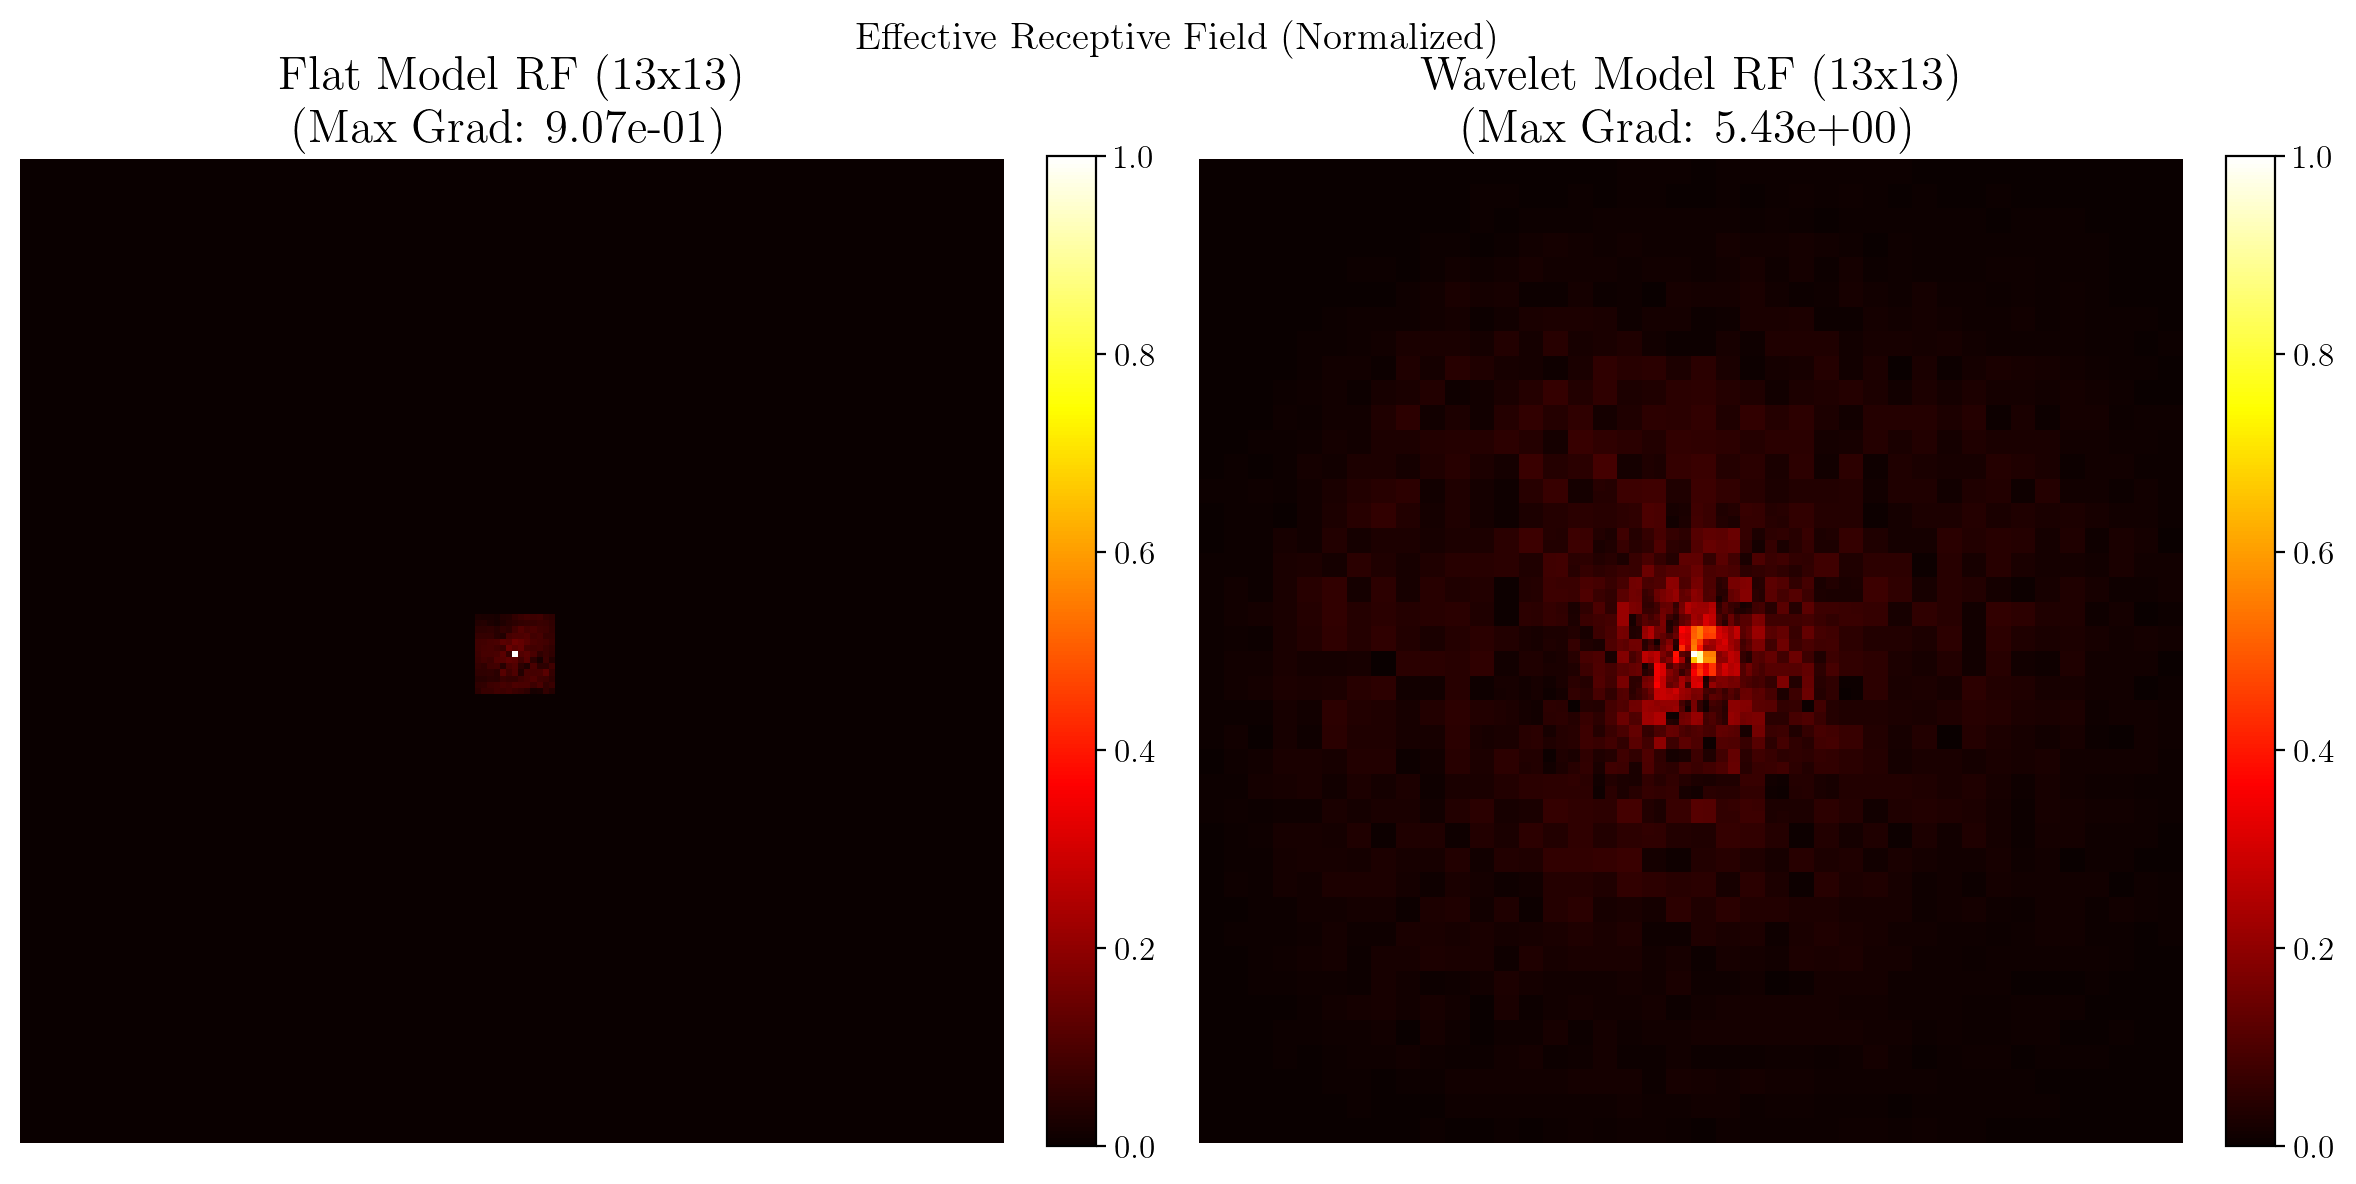

In [12]:
plt.figure(figsize=(12, 6))

# Plot Flat
plt.subplot(1, 2, 1)
robust_plot(grad_flat, f"Flat Model RF ({RF_SIZE}x{RF_SIZE})")

# Plot Wavelet
plt.subplot(1, 2, 2)
robust_plot(grad_ms, f"Wavelet Model RF ({RF_SIZE}x{RF_SIZE})")

plt.suptitle("Effective Receptive Field (Normalized)", fontsize=14)
plt.tight_layout()
plt.show()

## Interprétation des champs réceptifs

### Modèle Flat (CNN classique)
- **Champ réceptif** : Boîte de 13×13 pixels seulement
- **Problème** :
  - Ne voit pas le contexte global
  - Échoue sur les forts bruits (manque de structure globale)
  - Ne peut pas imaginer les détails fins de la structure globale

### Modèle Ondelettes Multi-échelles
- **Apparence similaire** : Utilise aussi des filtres 13×13
- **Différence clé** :
  - La carte de gradient montre que l'information vient de toute l'image
  - **Mécanisme** :
    - L'échelle grossière (40×40) voit toute l'image
    - Transmet cette information globale vers les échelles plus fines par transformée en ondelettes inverse successives
  - **Résultat** :
    - Champ réceptif global effectif
    - Peut "deviner" les détails manquants (Peut dessiner un nez au centre d'un visage)

### Conclusion
L'expérience montre que le modèle multi-échelles utilise effectivement toute l'image, contrairement au CNN classique limité à sa fenêtre locale. Cela lui permet d'exploiter la structure globale pour le débruitage.


# Expérience 3 : Débruitage d'une image basse résolution par le modèle multi-échelle 

Cherchons dans un premier temps a simplement débruiter l'image.

Input Low-Res Shape: torch.Size([1, 1, 40, 40]) (40x40 pixels)
Running Stochastic Super-Resolution... (This takes 10-20 seconds)
-------- torch.Size([1, 40, 40])
-------------------- scale:  1
-------- total number of iterations,  2
-------- average time per iteration (s),  0.007
-------- final sigma,  1.969331979751587
-------- final mean  -0.030515626072883606
-------- final snr,  -0.10774017311632633
-------- torch.Size([1, 80, 80])
-------- im range:  -0.0010702721774578094 1.0686298608779907
-------------------- scale:  0
----------------------------- 50
sigma  0.3761768937110901
mean  0.004039484541863203
----------------------------- 100
sigma  0.014641263522207737
mean  0.00013772632519248873
-------- total number of iterations,  139
-------- average time per iteration (s),  0.0161
-------- final sigma,  0.00018903166346717626
-------- final mean  0.0013007362140342593
-------- final snr,  40.09385585784912
-------- torch.Size([1, 160, 160])
-------- im range:  -0.0400721803307

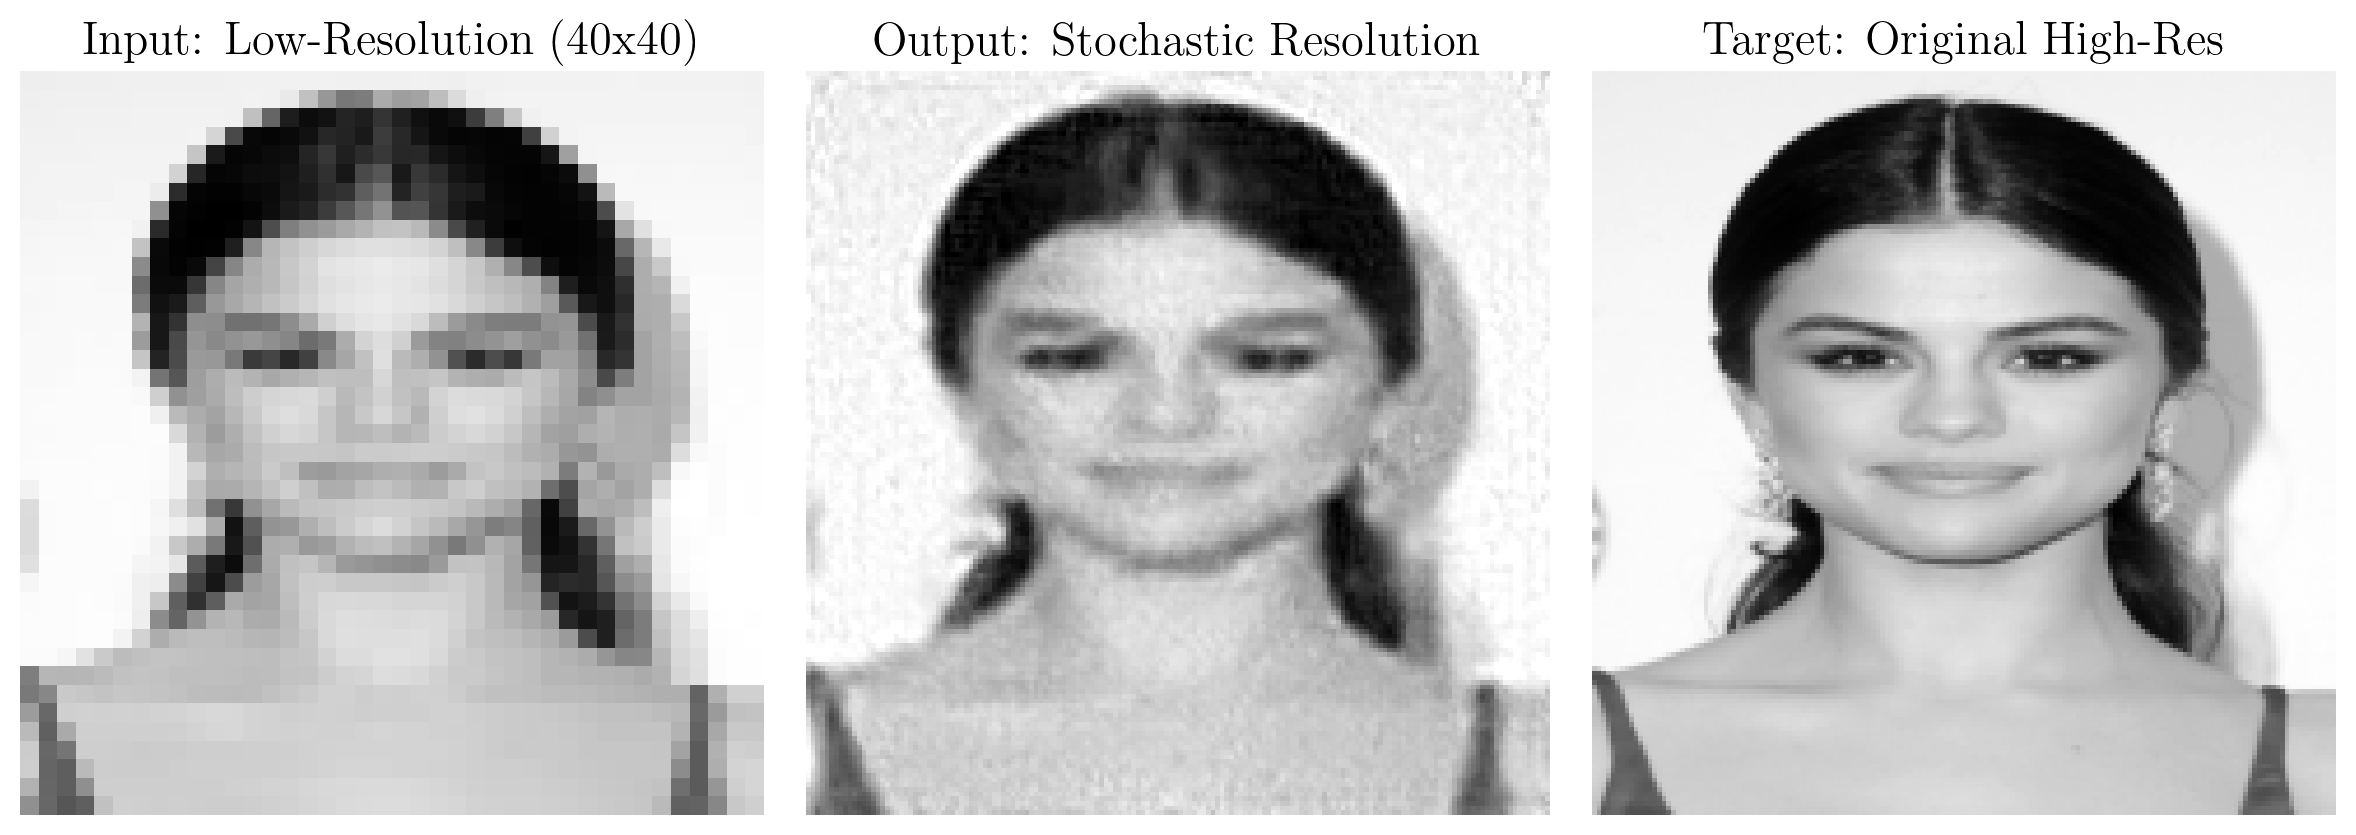

In [13]:
# 1. Prepare Low-Res Input (The "Condition")
# We decompose the image to Level 2 (40x40) and throw away the details
J = 2
with torch.no_grad():
    coeffs_list = multi_scale_decompose(test_im, J, device=device, orth_forward=True)
    # The last element holds the coarsest scale coefficients
    # Channel 0 is the Low-Pass (Average), Channels 1-3 are details
    coarse_coeffs = coeffs_list[-1]
    # We isolate ONLY the low-pass channel [B, 1, 40, 40]
    low_res_input = coarse_coeffs[:, 0:1, :, :]

print(f"Input Low-Res Shape: {low_res_input.shape} (40x40 pixels)")

# 2. Define Sampling Parameters (The "Schedule")
# These control the Langevin Dynamics loop (Gradient Descent with Noise)
# We need parameters for Scale 1 (40->80) and Scale 0 (80->160)
# Keys 1 and 0 refer to the scale index (1 is coarser, 0 is finest)

sampling_params = {
    # Start with high noise to explore diversity
    'sig_0': {1: 2.0, 0: 1.5},   
    
    # End with near-zero noise to converge
    'sig_L': {1: 0.01, 0: 0.01}, 
    
    # Step size (Learning rate for the generation)
    'h0':    {1: 0.1, 0: 0.05}, 
    
    # Beta controls the stochasticity (0 = deterministic, 1 = pure random walk)
    'beta':  {1: 0.05, 0: 0.05}, 
    
    # Logging frequency
    'freq':  {1: 50, 0: 50},
    
    # Use adaptive step size schedule
    'fixed_h': {1: False, 0: False} 
}

print("Running Stochastic Super-Resolution... (This takes 10-20 seconds)")
init_im_3d = low_res_input.squeeze(0)
generated_images, _, _ = multi_scale_synthesis(
    ms_denoisers, 
    init_im=init_im_3d,
    sig_0=sampling_params['sig_0'],
    sig_L=sampling_params['sig_L'],
    h0=sampling_params['h0'],
    beta=sampling_params['beta'],
    freq=sampling_params['freq'],
    device=device,
    fixed_h=sampling_params['fixed_h'],
    seeds={1: None, 0: None, 'low': None} 
)

# The final result is the last image in the list
super_res_im = generated_images[-1]

# 4. Visualization (Same as before)
plt.figure(figsize=(12, 5))

# A. Low-Res Input
plt.subplot(1, 3, 1)
plt.imshow(low_res_input.squeeze().cpu(), cmap='gray', interpolation='nearest')
plt.title("Input: Low-Resolution (40x40)")
plt.axis('off')

# B. Stochastic Output
plt.subplot(1, 3, 2)
plt.imshow(super_res_im.squeeze().clamp(0,1).cpu(), cmap='gray')
plt.title("Output: Stochastic Resolution")
plt.axis('off')

# C. Original
plt.subplot(1, 3, 3)
plt.imshow(test_im.squeeze().cpu(), cmap='gray')
plt.title("Target: Original High-Res")
plt.axis('off')

plt.tight_layout()
plt.show()

# Expérience 4 : Démonstration des capacités de génération du modèle

Cette expérience vise à prouver que le modèle est capable de générer des détails non présents dans l'image d'entrée, un phénomène appelé *hallucination* en traitement d'images. Nous démontrons cela en produisant deux images différentes à partir d'une même image basse résolution, simplement en changeant la *seed* aléatoire utilisée.



-------- torch.Size([1, 40, 40])
-------------------- scale:  1
-------- total number of iterations,  2
-------- average time per iteration (s),  0.0072
-------- final sigma,  2.0112907886505127
-------- final mean  -0.010453075170516968
-------- final snr,  0.0050131825264543295
-------- torch.Size([1, 80, 80])
-------- im range:  -0.015200454741716385 1.0841543674468994
-------------------- scale:  0
----------------------------- 50
sigma  0.3852415382862091
mean  -0.0006304088165052235
----------------------------- 100
sigma  0.012328754179179668
mean  6.15804674453102e-05
-------- total number of iterations,  141
-------- average time per iteration (s),  0.0143
-------- final sigma,  0.000196827037143521
-------- final mean  0.0013431889237836003
-------- final snr,  40.036516189575195
-------- torch.Size([1, 160, 160])
-------- im range:  -0.041861142963171005 1.236030101776123
-------- torch.Size([1, 40, 40])
-------------------- scale:  1
-------- total number of iterations,  2


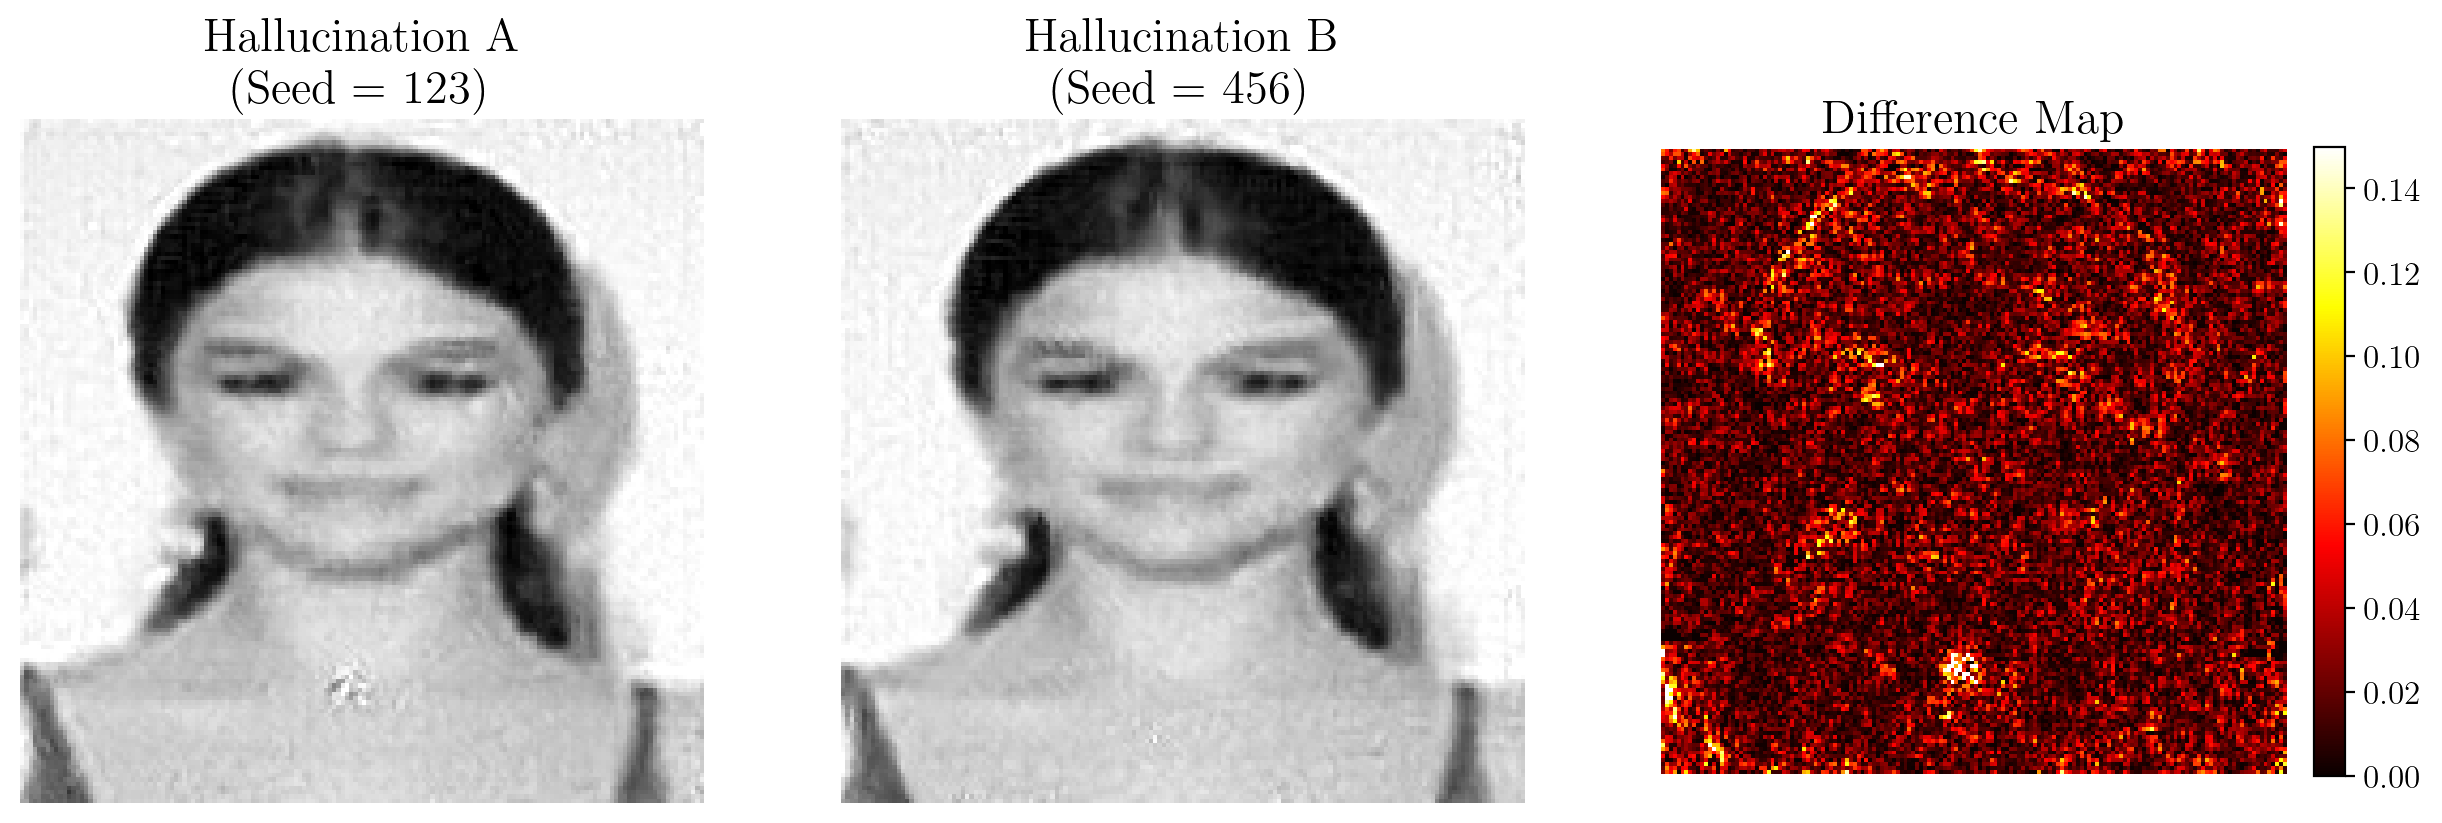

In [14]:
# Goal: Prove the model is 'hallucinating' by generating two different outcomes from the EXACT SAME low-res input.

# 1. Define Two Different Random Seeds
# We keep the input (init_im_3d) exactly the same.
seeds_A = {1: 123, 0: 123, 'low': 123}
seeds_B = {1: 456, 0: 456, 'low': 456} 

# 2. Sample A
gen_A, _, _ = multi_scale_synthesis(
    ms_denoisers, init_im=init_im_3d, 
    sig_0=sampling_params['sig_0'], sig_L=sampling_params['sig_L'], 
    h0=sampling_params['h0'], beta=sampling_params['beta'], 
    freq=sampling_params['freq'], device=device, fixed_h=sampling_params['fixed_h'],
    seeds=seeds_A
)

# 3. Sample B
gen_B, _, _ = multi_scale_synthesis(
    ms_denoisers, init_im=init_im_3d, 
    sig_0=sampling_params['sig_0'], sig_L=sampling_params['sig_L'], 
    h0=sampling_params['h0'], beta=sampling_params['beta'], 
    freq=sampling_params['freq'], device=device, fixed_h=sampling_params['fixed_h'],
    seeds=seeds_B
)

# 4. Prepare Images
img_A = gen_A[-1].squeeze().clamp(0,1).cpu()
img_B = gen_B[-1].squeeze().clamp(0,1).cpu()

# 5. Visualize Differences
plt.figure(figsize=(15, 6))

# Show Generation A
plt.subplot(1, 3, 1)
plt.imshow(img_A, cmap='gray')
plt.title("Hallucination A\n(Seed = 123)")
plt.axis('off')

# Show Generation B
plt.subplot(1, 3, 2)
plt.imshow(img_B, cmap='gray')
plt.title("Hallucination B\n(Seed = 456)")
plt.axis('off')

# Show Difference
diff = (img_A - img_B).abs()
plt.subplot(1, 3, 3)
plt.imshow(diff, cmap='hot', vmin=0, vmax=0.15) 
plt.title("Difference Map")
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

# Analyse des résultats de génération

Cette expérience démontre clairement la capacité du modèle à générer des variations plausibles à partir d'une même image d'entrée basse résolution en utilisant des *seed* aléatoires différentes. 
Les deux images générées présentent des similarités dans les traits principaux du visage, tout en montrant des différences subtiles dans les détails et les contours, notamment au niveau du crâne et des cheveux. La différence map met en évidence ces variations, avec des écarts allant jusqu'à 0.14 en intensité, principalement dans les zones texturées et ambigües. Ces résultats montrent que le modèle possède une certaine intelligence perceptuelle, capable d'interpréter et de compléter les informations manquantes de manière cohérente mais variable, ce qui pourrait être exploité pour des applications pratiques comme l'amélioration d'images ou la génération de contenus.


Running High-Variance Generation...
-------- torch.Size([1, 40, 40])
-------------------- scale:  1
-------- total number of iterations,  2
-------- average time per iteration (s),  0.0057
-------- final sigma,  1.9651621580123901
-------- final mean  -0.00650651752948761
-------- final snr,  -0.0364809762686491
-------- torch.Size([1, 80, 80])
-------- im range:  -0.013796757906675339 1.0693016052246094
-------------------- scale:  0
----------------------------- 50
sigma  1.2130365371704102
mean  -0.0068181101232767105
----------------------------- 100
sigma  0.9639791250228882
mean  -0.007432141341269016
----------------------------- 150
sigma  0.7169108986854553
mean  -0.002705544466152787
----------------------------- 200
sigma  0.5514363646507263
mean  -0.00014036838547326624
----------------------------- 250
sigma  0.42396751046180725
mean  0.0008800934883765876
----------------------------- 300
sigma  0.30325567722320557
mean  0.0005621929885819554
-----------------------------

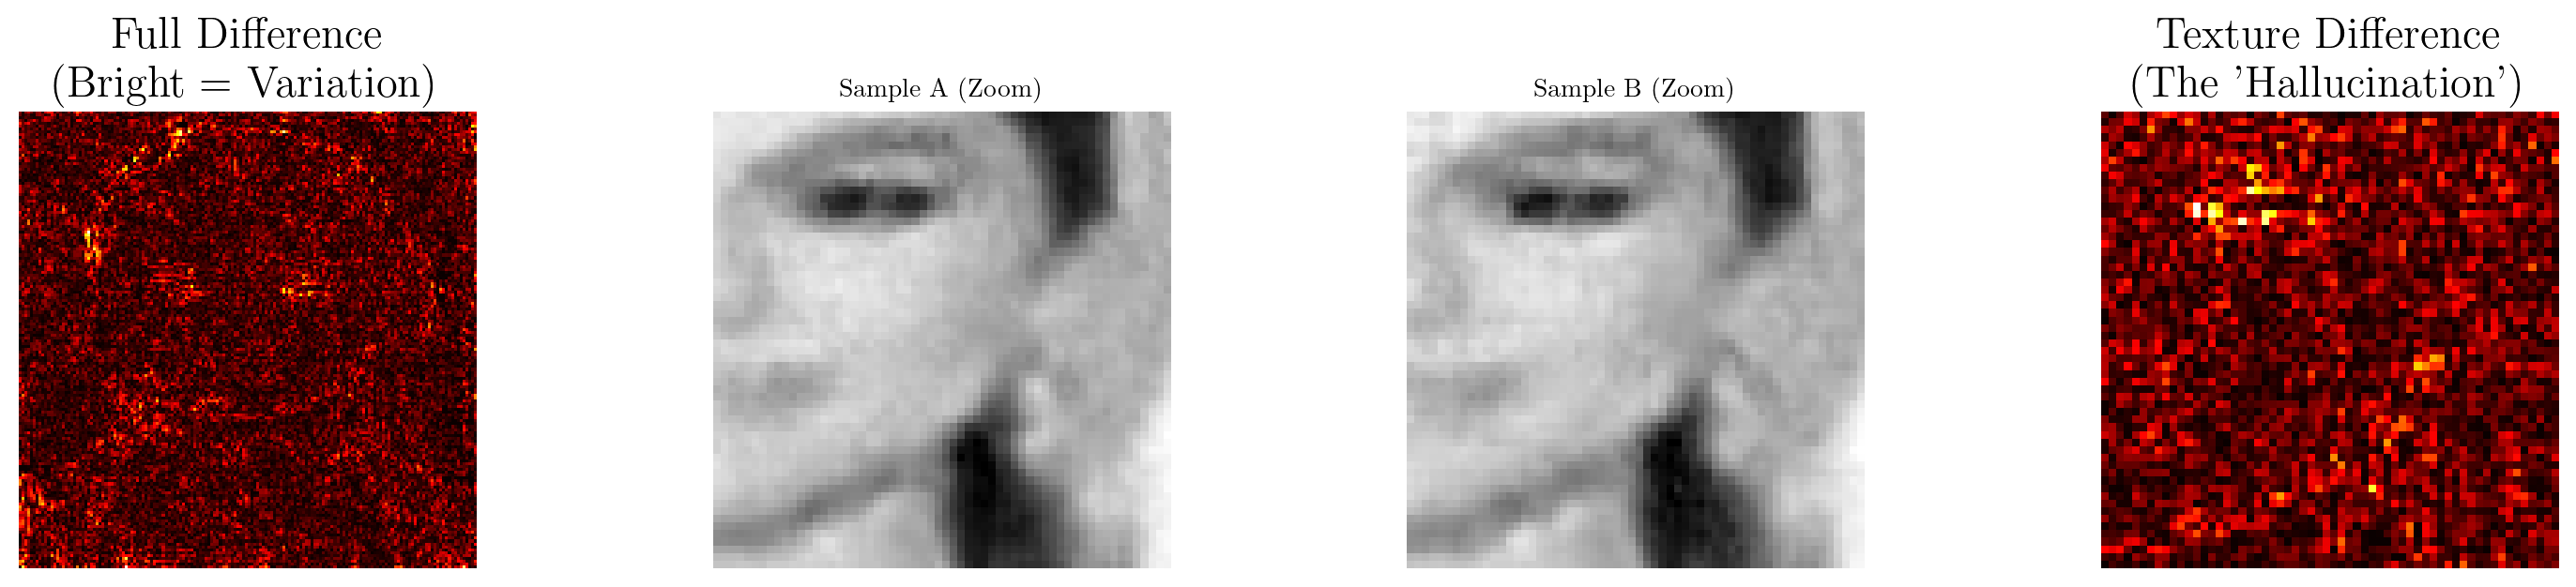

Max Pixel Difference: 0.2026
Mean Pixel Difference: 0.0225


In [15]:
import copy

# Goal: Prove the model is "hallucinating" by generating two DIFFERENT outcomes from the EXACT SAME low-res input.

print("Running High-Variance Generation...")

params_high_var = copy.deepcopy(sampling_params)

# Beta close to 0 = High Noise (Langevin Dynamics dominates)
# We set both scales to 0.01 to force the model to invent details
params_high_var['beta'] = {1: 0.001, 0: 0.001} 
params_high_var['h0']   = {1: 0.2,  0: 0.15} # Increase step size slightly to help exploration

gen_A_high, _, _ = multi_scale_synthesis(
    ms_denoisers, init_im=init_im_3d, 
    sig_0=sampling_params['sig_0'], sig_L=sampling_params['sig_L'], 
    h0=params_high_var['h0'], beta=params_high_var['beta'], 
    freq=sampling_params['freq'], device=device, fixed_h=sampling_params['fixed_h'],
    seeds={1: 101, 0: 101, 'low': 101}
)

gen_B_high, _, _ = multi_scale_synthesis(
    ms_denoisers, init_im=init_im_3d, 
    sig_0=sampling_params['sig_0'], sig_L=sampling_params['sig_L'], 
    h0=params_high_var['h0'], beta=params_high_var['beta'], 
    freq=sampling_params['freq'], device=device, fixed_h=sampling_params['fixed_h'],
    seeds={1: 202, 0: 202, 'low': 202}
)

img_A = gen_A_high[-1].squeeze().clamp(0,1).cpu()
img_B = gen_B_high[-1].squeeze().clamp(0,1).cpu()

# 4. Zoom Function (Helper)
def plot_zoom(img, ax, title):
    h, w = img.shape
    patch = img[h//2-30:h//2+30, w//2:w//2+60] # Zoom on eye/cheek area
    ax.imshow(patch, cmap='gray')
    ax.set_title(title, fontsize=10)
    ax.axis('off')
    return patch

# 5. Visualization
plt.figure(figsize=(15, 6))

# Full Difference
diff = (img_A - img_B).abs()
ax1 = plt.subplot(2, 4, 1)
ax1.imshow(diff, cmap='hot', vmin=0)
ax1.set_title("Full Difference\n(Bright = Variation)")
ax1.axis('off')

# Zoomed Views
ax2 = plt.subplot(2, 4, 2); patch_A = plot_zoom(img_A, ax2, "Sample A (Zoom)")
ax3 = plt.subplot(2, 4, 3); patch_B = plot_zoom(img_B, ax3, "Sample B (Zoom)")

# Zoomed Difference
ax4 = plt.subplot(2, 4, 4)
diff_patch = (patch_A - patch_B).abs()
ax4.imshow(diff_patch, cmap='hot', vmin=0) 
ax4.set_title("Texture Difference\n(The 'Hallucination')")
ax4.axis('off')

plt.tight_layout()
plt.show()

print(f"Max Pixel Difference: {diff.max().item():.4f}")
print(f"Mean Pixel Difference: {diff.mean().item():.4f}")

Le zoom montre encore que les différences se font sur les zones les plus texturée (les yeux ici).

Cette expérience utilise des paramètres volontairement "aberrant" pour exagérer les capacités d'hallucination du modèle. 

 **Paramètres modifiés** :
   - `beta` est réglé à 0.01 (contre 1 dans l'expérience normale) pour maximiser le bruit stochastique
   - `h0` est augmenté pour forcer des divergences plus importantes entre les itérations
   - `sig_0` commence avec un fort  niveau de bruit (4.0)

-------- torch.Size([1, 40, 40])
-------------------- scale:  1
-------- total number of iterations,  2
-------- average time per iteration (s),  0.01
-------- final sigma,  4.067078590393066
-------- final mean  -0.12107451260089874
-------- final snr,  6.1810749769210815
-------- torch.Size([1, 80, 80])
-------- im range:  -0.20878943800926208 1.2781625986099243
-------------------- scale:  0
-------- total number of iterations,  2
-------- average time per iteration (s),  0.0084
-------- final sigma,  4.040203094482422
-------- final mean  0.004476243630051613
-------- final snr,  -0.03347128629684448
-------- torch.Size([1, 160, 160])
-------- im range:  -0.29007047414779663 1.4670579433441162
-------- torch.Size([1, 40, 40])
-------------------- scale:  1
-------- total number of iterations,  2
-------- average time per iteration (s),  0.0033
-------- final sigma,  3.99320650100708
-------- final mean  -0.19323119521141052
-------- final snr,  6.070283055305481
-------- torch.Size

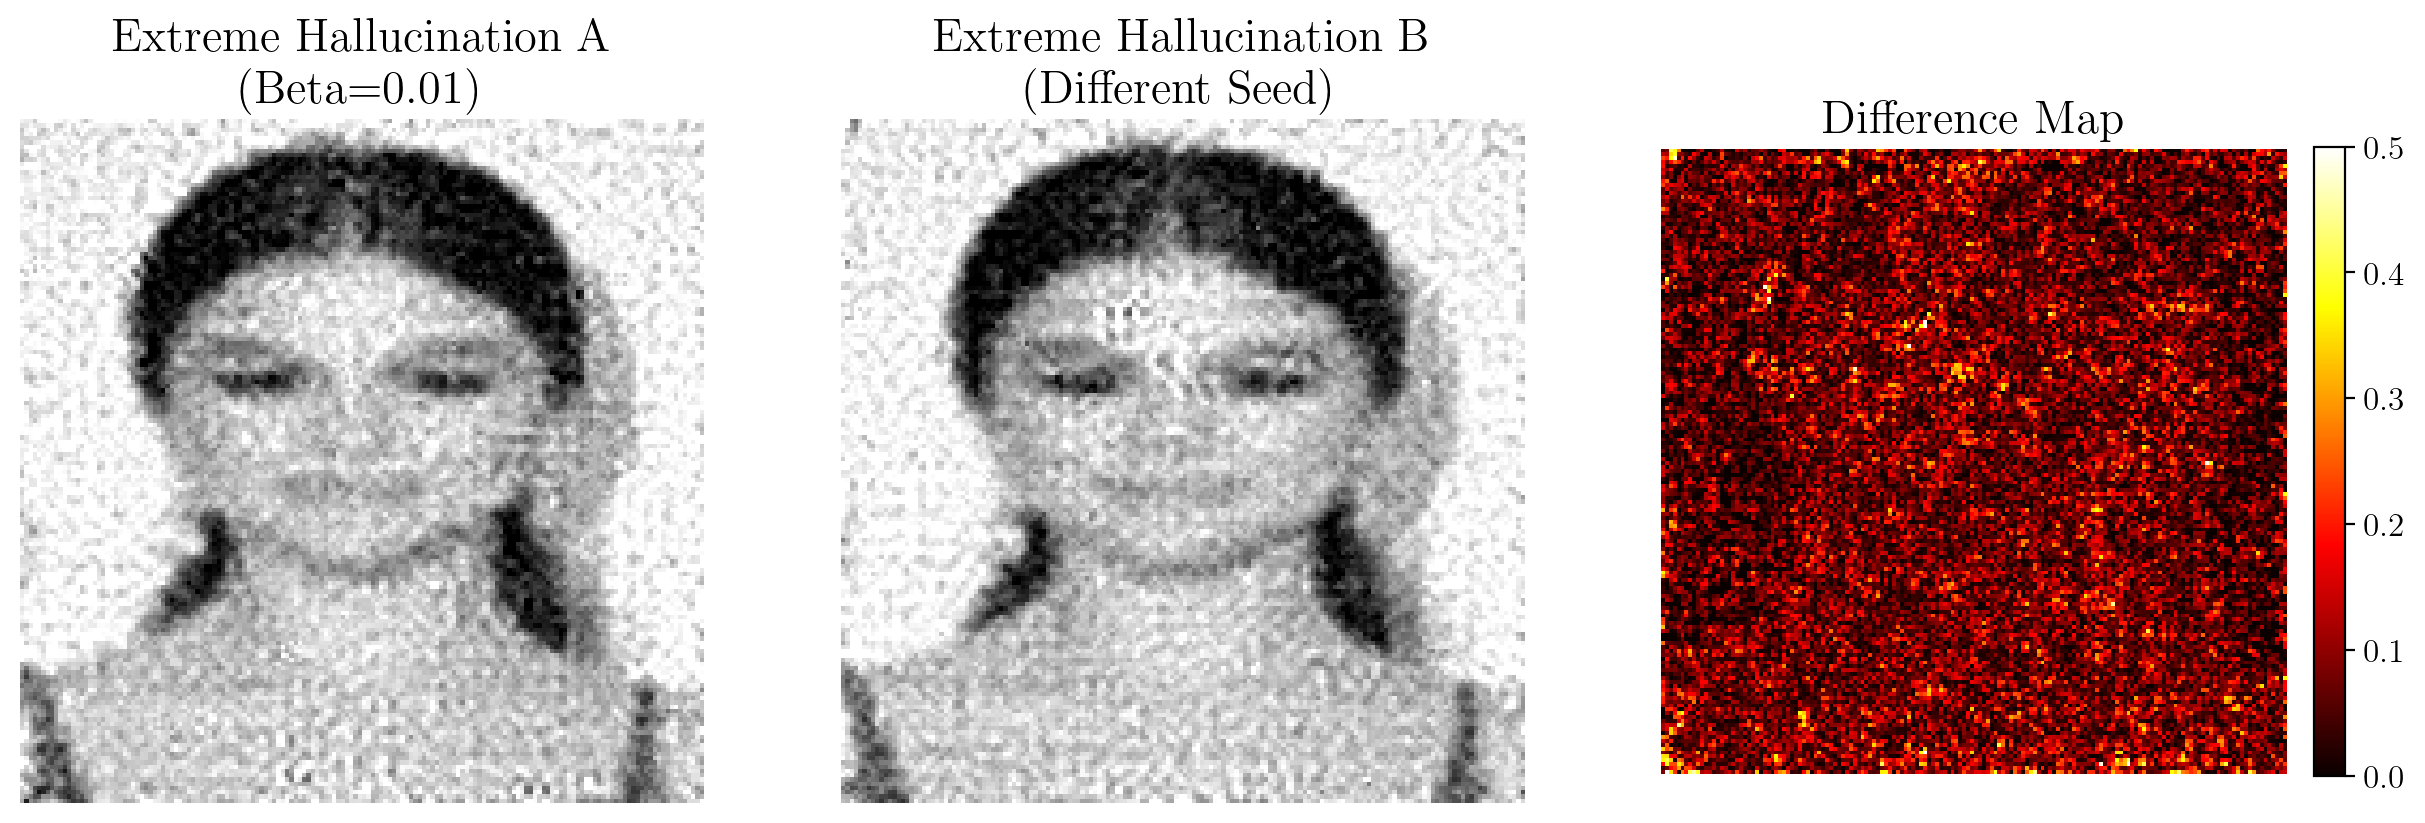

Max Pixel Difference: 0.5947
Mean Difference: 0.0805


In [16]:
# 1. Define "Absurd" Parameters
# CORRECTION: beta close to 0 = Maximum Noise (beta=1 is deterministic)
params_absurd = sampling_params.copy()
params_absurd['beta']  = {1: 1e1, 0: 0.01}   # <--- FIX: Massive stochasticity
params_absurd['h0']    = {1: 0.3, 0: 0.15}    # <--- FIX: Larger steps to force divergence
params_absurd['sig_0'] = {1: 4.0, 0: 4.0}     # <--- FIX: Start with huge noise

gen_A_absurd, _, _ = multi_scale_synthesis(
    ms_denoisers, init_im=init_im_3d, 
    sig_0=params_absurd['sig_0'], sig_L=sampling_params['sig_L'], 
    h0=params_absurd['h0'], beta=params_absurd['beta'], 
    freq=sampling_params['freq'], device=device, fixed_h=sampling_params['fixed_h'],
    seeds={1: 777, 0: 777, 'low': 777}
)

gen_B_absurd, _, _ = multi_scale_synthesis(
    ms_denoisers, init_im=init_im_3d, 
    sig_0=params_absurd['sig_0'], sig_L=sampling_params['sig_L'], 
    h0=params_absurd['h0'], beta=params_absurd['beta'], 
    freq=sampling_params['freq'], device=device, fixed_h=sampling_params['fixed_h'],
    seeds={1: 888, 0: 888, 'low': 888}
)

img_A = gen_A_absurd[-1].squeeze().clamp(0,1).cpu()
img_B = gen_B_absurd[-1].squeeze().clamp(0,1).cpu()

# 3. Visualize
plt.figure(figsize=(15, 6))

# Sample A
plt.subplot(1, 3, 1)
plt.imshow(img_A, cmap='gray')
plt.title("Extreme Hallucination A\n(Beta=0.01)")
plt.axis('off')

# Sample B
plt.subplot(1, 3, 2)
plt.imshow(img_B, cmap='gray')
plt.title("Extreme Hallucination B\n(Different Seed)")
plt.axis('off')

# Difference
diff = (img_A - img_B).abs()
plt.subplot(1, 3, 3)
# We can increase vmax to 0.5 because differences should be huge now
plt.imshow(diff, cmap='hot', vmin=0, vmax=0.5) 
plt.title("Difference Map")
plt.axis('off')
plt.colorbar(fraction=0.046, pad=0.04)

plt.show()

print(f"Max Pixel Difference: {diff.max().item():.4f}")
print(f"Mean Difference: {diff.mean().item():.4f}")

On remarque que les différences sont plus importantes qu'avant (la Difference Map monte à 0.5 par endroit contre 0.14). Ces paramètres extrêmes révèlent les limites du modèle : La forte différence entre les deux images générées à partir de la même entrée démontre la sensibilité du modèle aux paramètres de bruit et de pas.

## Conclusion

Ce notebook explore une approche pour modéliser des distributions d'images via une décomposition multi-échelle en ondelettes, combinée à des réseaux de neurones convolutifs locaux. 

Les résultats montrent que cette méthode réduit efficacement la dimensionnalité tout en préservant la qualité des reconstructions, avec des performances compétitives en synthèse d'images et super-résolution. 

Cependant, la sensibilité aux paramètres (bruit initial, pas de gradient) et les hallucinations observées pour des configurations extrêmes soulignent les limites du modèle. 

Cette approche ouvre des perspectives pour des applications en génération d'images, compression ou traitement multi-échelle, mais nécessiterait des améliorations pour une meilleure stabilité et généralisation.

